# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

## Setup
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/FAIR-Universe/HEP-Challenge.git
    !pip install iminuit

    # move to the HEP starting kit folder
    %cd HEP-Challenge/

In [3]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": False, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "ttbar_scale": False, # ttbar scale factor
    "diboson_scale": False, # diboson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 100 , # Number of pseudo-experiments to run per set
"num_of_sets" : 1, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True

## Existing Submissions
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

### Imports

In [4]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys
warnings.filterwarnings("ignore")

### Directories

In [5]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

input_dir = os.path.join(root_dir, "input_data")
output_dir = os.path.join(root_dir, "sample_result_submission")
submission_dir = os.path.join(root_dir, "sample_code_submission")
program_dir = os.path.join(root_dir, "ingestion_program")
score_dir = os.path.join(root_dir, "scoring_program")
    
test_settings = TEST_SETTINGS.copy()

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = [1,] # (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)


Root directory is /clusterfs/ml4hep/jvdudley/projects/FairUniverse/examples/HEP-Challenge



### Add directories to path

In [6]:
path.append(program_dir)
path.append(submission_dir)
path.append(score_dir)

***
# Internal imports
***

In [7]:
from visualization import *
from systematics import systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [8]:
from model import Model
from datasets import Data

***
## Data
***

### ⚠️ Note:
The data used here is a small sample data is for demonstration only to get a view of what the data looks like. 

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small sample datafor quick execution of this notebook

In [9]:
USE_PUBLIC_DATASET = True

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [10]:
if USE_PUBLIC_DATASET:
    from datasets import Neurips2024_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [11]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79886911 entries, 0 to 79886910
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(28)
memory usage: 8.3 GB
None
[+] Train data loaded successfully


In [12]:
# load test sets
data.load_test_set()

[*] Loading Test data
[+] Test data loaded successfully


***
# Visualize
***
- Visualize Train set

In [13]:
train_visualize = Dataset_visualise(
    data_set=data.get_train_set(),
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "DER_mass_vis",
        "DER_mass_jet_jet",
        "DER_sum_pt",
    ],
    name="Train Set",
)

In [14]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 79886911
[*] --- Number of features : 28
   diboson   13613.139264533414
   htautau   3653.8143033363444
   ttbar   159011.06251448215
   ztautau   3593294.2302822294
[*] --- Number of signal events : 42339374
[*] --- Number of background events : 37547537
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,29.906000,0.474,-0.251,60.577000,-0.230,2.188,60.577000,-0.230,2.188,23.208000,...,17.773001,4.058,285.545013,0.988,2.538,67.510002,174.268005,0.494,-1.144,0.163
1,46.884998,1.973,0.329,29.836000,1.013,-2.915,29.836000,1.013,-2.915,-25.000000,...,11.657000,-25.000,-25.000000,-25.000,3.187,30.629000,106.556999,1.571,1.407,-25.000
2,46.688000,0.620,-1.243,72.199997,0.869,1.477,72.199997,0.869,1.477,23.726000,...,22.035999,3.317,219.098007,3.636,2.731,73.988998,214.813004,0.647,-0.731,0.266
3,32.073002,-1.457,2.068,63.521000,-0.914,-1.567,63.521000,-0.914,-1.567,24.698000,...,33.459000,3.206,204.399994,-2.094,2.703,72.735001,207.100998,0.505,-1.413,0.166
4,20.296000,1.961,-3.137,56.077000,1.221,-0.245,56.077000,1.221,-0.245,39.814999,...,38.743000,1.092,94.107002,0.157,2.985,69.587997,172.264999,0.362,1.410,0.004


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,...,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07,7.988691e+07
mean,3.572287e+01,6.109558e-05,1.577518e-04,4.570840e+01,-5.156677e-05,2.633816e-04,6.274007e+01,-1.151843e-04,3.076432e-05,1.502228e+01,...,4.907956e+01,-1.059991e+01,1.075947e+02,-1.136068e+01,2.679708e+00,5.441272e+01,1.884865e+02,8.889660e-01,3.366899e-01,-1.137871e+01
std,1.978092e+01,1.204731e+00,1.813495e+00,2.371735e+01,1.229004e+00,1.813658e+00,5.075151e+01,1.482602e+00,1.812874e+00,4.413786e+01,...,6.107854e+01,1.342214e+01,2.394889e+02,1.284964e+01,6.433567e-01,3.579956e+01,1.352342e+02,5.558856e-01,1.188398e+00,1.266325e+01
min,2.000000e+01,-2.501000e+00,-3.142000e+00,2.284400e+01,-2.706000e+00,-3.142000e+00,2.287500e+01,-4.971000e+00,-3.142000e+00,-2.500000e+01,...,1.000000e-03,-2.500000e+01,-2.500000e+01,-2.500000e+01,4.900000e-01,3.000000e-03,6.590600e+01,1.300000e-02,-1.414000e+00,-2.500000e+01
25%,2.443100e+01,-9.280000e-01,-1.570000e+00,3.169200e+01,-9.540000e-01,-1.570000e+00,3.549200e+01,-1.086000e+00,-1.571000e+00,-2.500000e+01,...,1.247600e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,2.385000e+00,3.452600e+01,1.066700e+02,5.710000e-01,-1.254000e+00,-2.500000e+01
50%,3.016600e+01,0.000000e+00,0.000000e+00,4.004800e+01,0.000000e+00,0.000000e+00,4.633400e+01,0.000000e+00,0.000000e+00,2.478500e+01,...,2.567200e+01,2.090000e-01,4.930300e+01,-3.495000e+00,2.912000e+00,4.729200e+01,1.418130e+02,7.700000e-01,1.039000e+00,0.000000e+00
75%,3.960900e+01,9.280000e-01,1.571000e+00,5.176800e+01,9.540000e-01,1.571000e+00,6.720600e+01,1.086000e+00,1.571000e+00,4.065200e+01,...,6.041100e+01,1.674000e+00,1.489540e+02,3.270000e-01,3.114000e+00,6.434500e+01,2.172550e+02,1.040000e+00,1.382000e+00,3.500000e-01
max,1.459470e+03,2.501000e+00,3.142000e+00,1.767040e+03,2.697000e+00,3.142000e+00,1.891370e+03,4.991000e+00,3.142000e+00,1.672120e+03,...,2.320391e+03,9.666000e+00,9.023132e+03,2.173500e+01,5.963000e+00,1.908688e+03,5.255498e+03,6.166400e+01,1.414000e+00,1.000000e+00


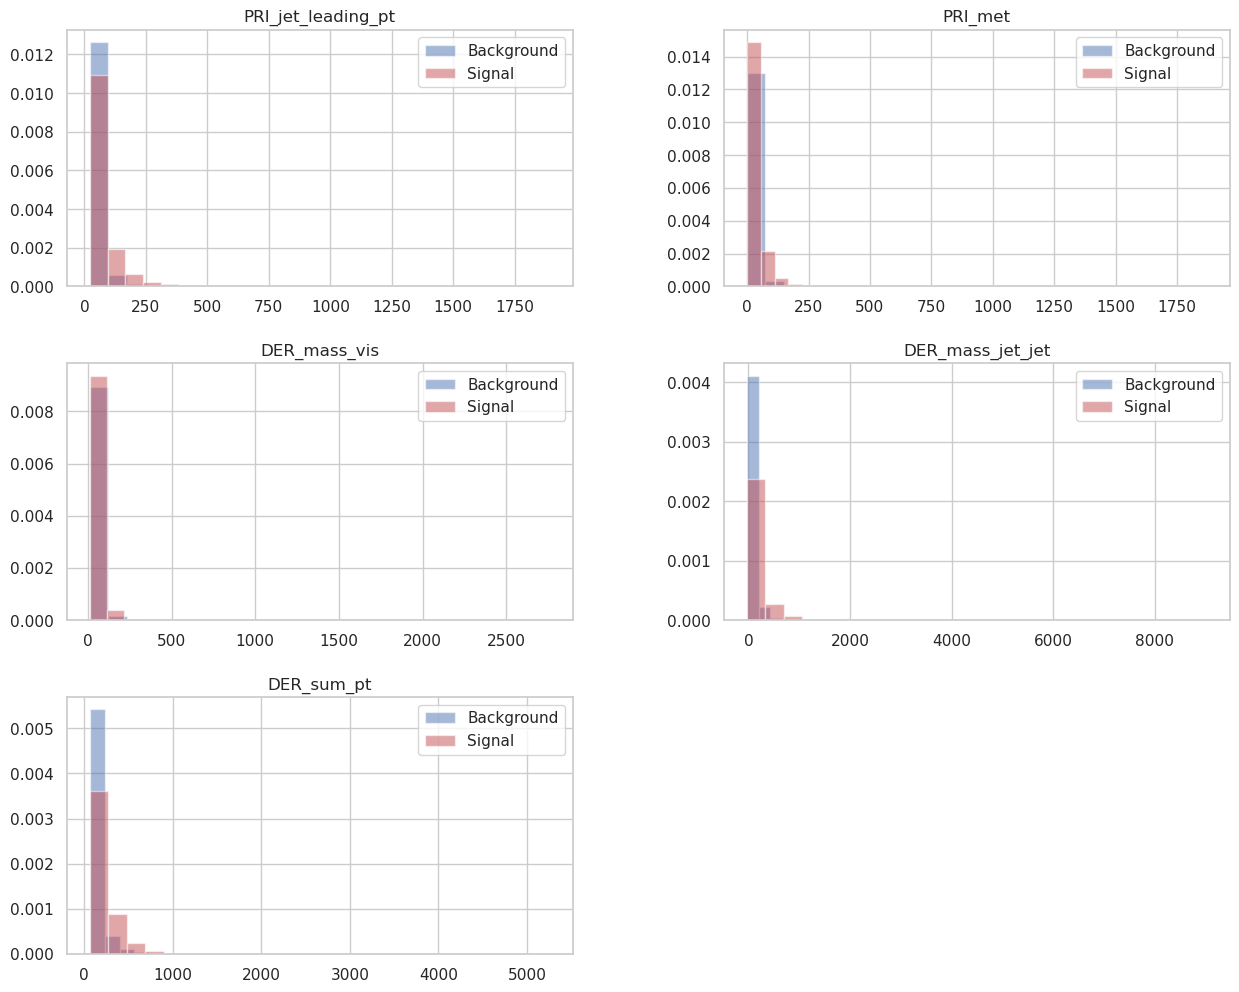

In [15]:
# Show data summary
train_visualize.histogram_dataset()

diboson (136129,)
diboson (136129,)
htautau (30,)
ttbar (1590109,)
ttbar (1590109,)
ztautau (35821299,)
ztautau (35821299,)


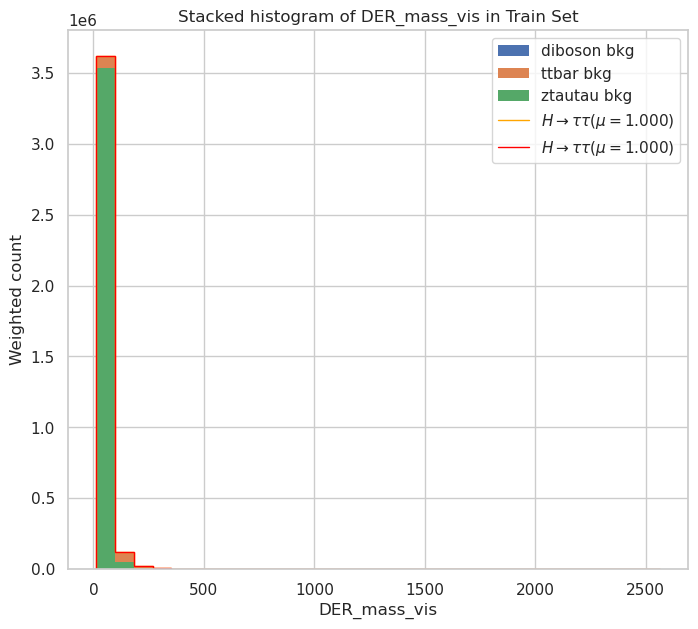

In [16]:
train_visualize.stacked_histogram("DER_mass_vis")

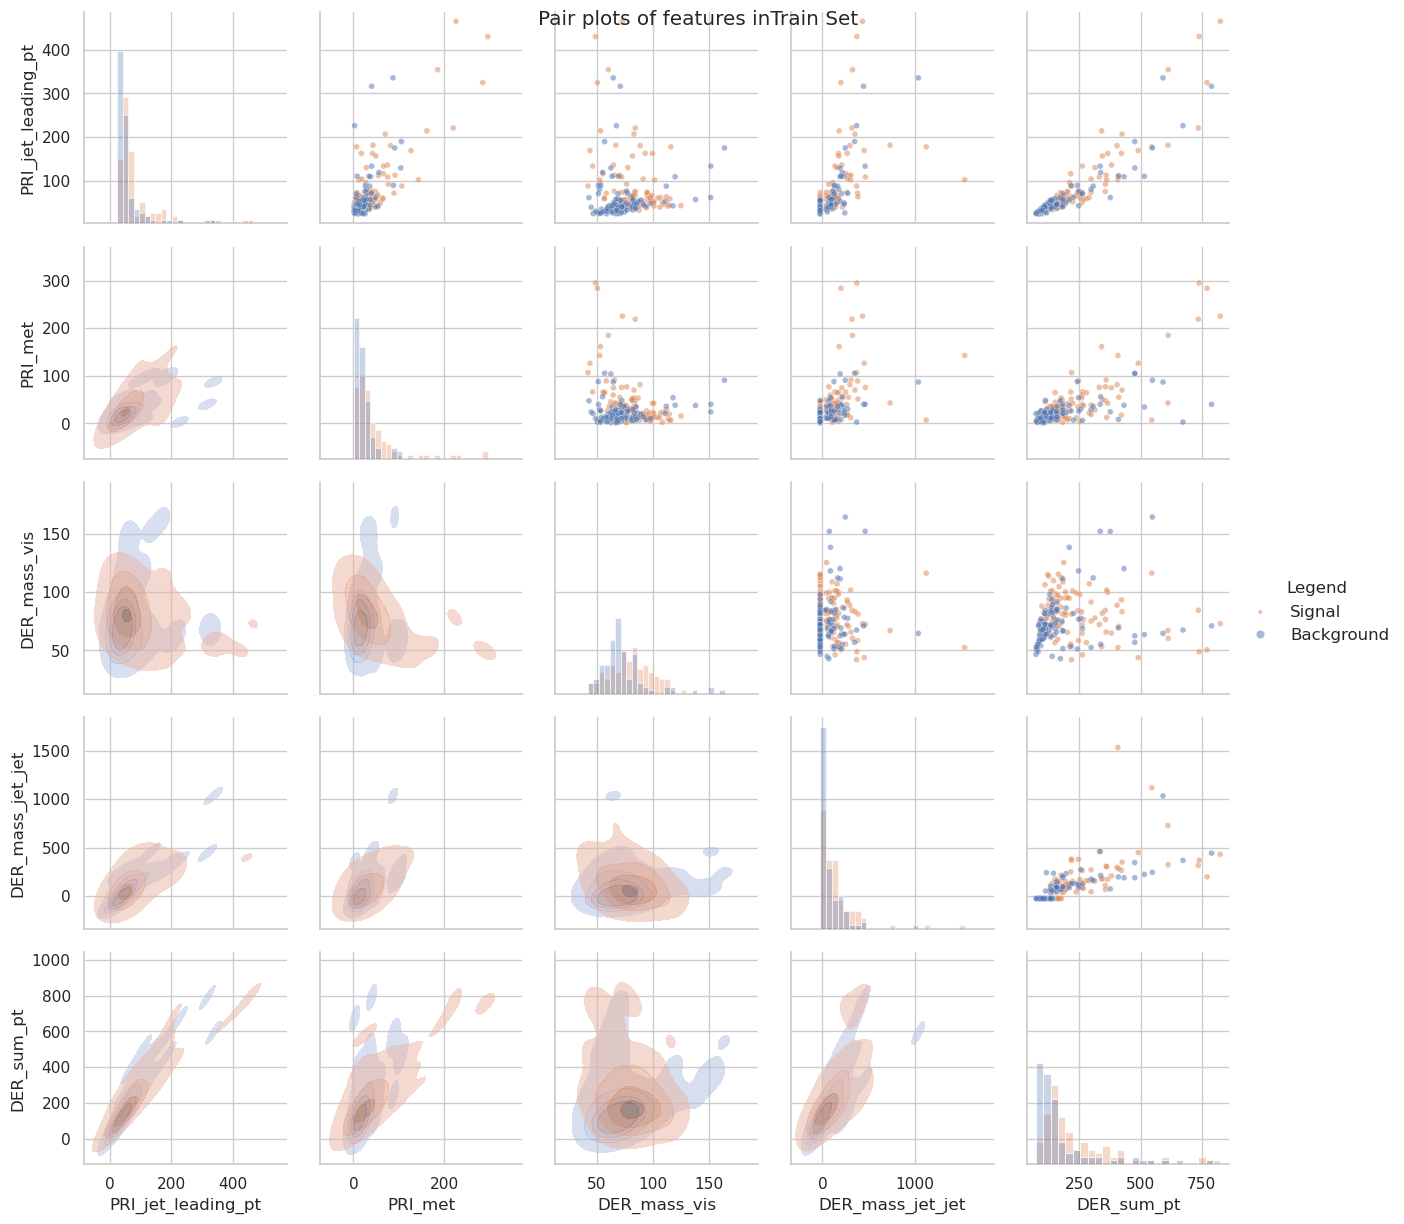

In [17]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

In [18]:
syst_train_data = data.get_syst_train_set()

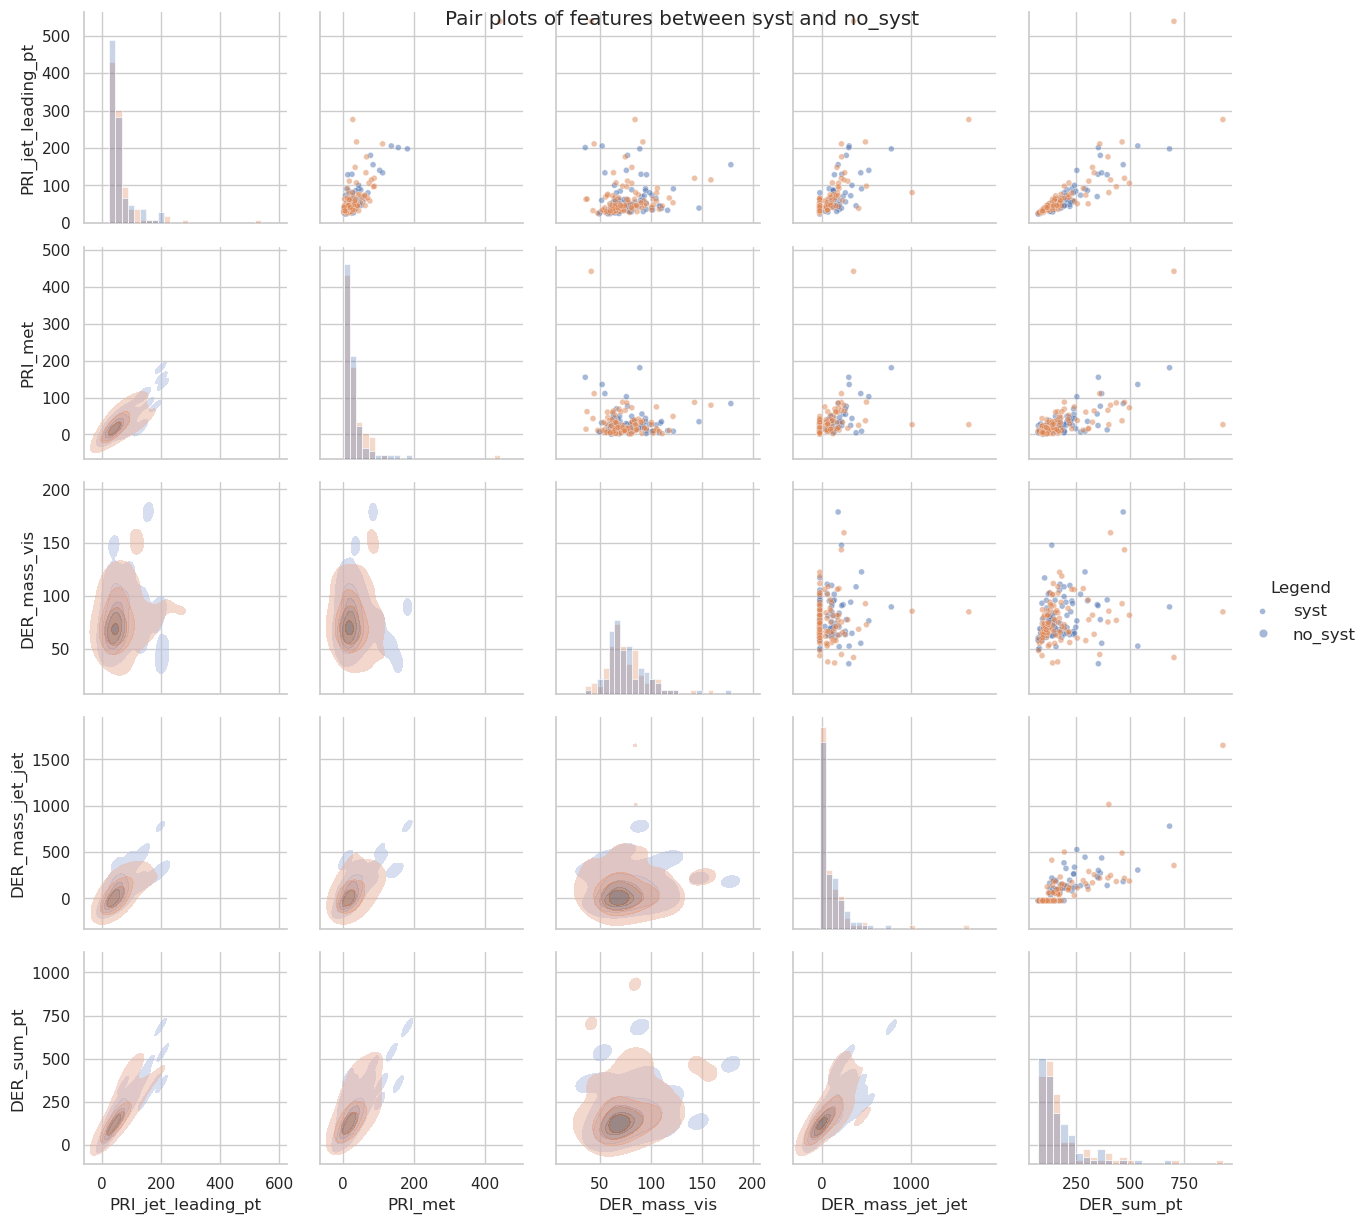

In [19]:
# Pair plots of train set with systematics
train_visualize.pair_plots_syst(syst_train_data["data"], sample_size=100)

In [20]:
bootstraped_data = data.generate_pseudo_exp_data()

TypeError: get_bootstrapped_dataset() got an unexpected keyword argument 'return_labels'

In [ ]:
# Show data summary
train_visualize.examine_dataset()

In [ ]:
print("sum of weights = ", (bootstraped_data["weights"]).sum())

***
# Program
***


In [13]:

from ingestion import Ingestion

ingestion = Ingestion(data)


In [14]:

# initialize submission
ingestion.init_submission(Model)

[*] Initializing Submmited Model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79886911 entries, 0 to 79886910
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(28)
memory usage: 8.3 GB
None
[+] Train data loaded successfully
Full data:  (79886911, 28)
Full Labels:  (79886911,)
Full Weights:  (79886911,)
sum_signal_weights:  3653.8143033363444
sum_bkg_weights:  3765918.432061284
 
 
Full size of the data is 79886911
Train size is 39943456
Test size is 39943455
Full size of the data is 39943455
Train size is 19971728
Test size is 19971727
Training Set:
-------- 
  Data Shape:          (39943456, 28)
  Labels Shape:        (39943456,)
  Weights Shape:       (39943456,)
  Sum Signal Weights:  3653.81
  Sum Background Weights: 3765918.43


Validation Set:
---------- 
  Data Shape:          (19971728, 28)
  Labels Shape:        (19971728,)
  Weights Shape:       (19971728,)
  Sum Signal Weights:  3653.81
  Sum Background Weights: 3765918.43

2024-08-02 16:34:27.492878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 16:34:27.492912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 16:34:27.493824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 16:34:27.499287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 16:34:34.849253:

8 Physical GPUs, 1 Logical GPUs
Model is TF NN


## Statistical Tools
In the process of data fitting using our ingestion module, there are two primary arguments that control how the fit is performed: stat_only and syst_settings.
- `stat_only (bool, optional)`: This argument, when set to True, forces the fitting process to compute statistics-only results. This means that only statistical uncertainties are considered, and all systematic uncertainties are ignored.
- `syst_settings (dict, optional)`: This argument is a dictionary that specifies the systematic settings, indicating whether to fix certain systematics during the fitting process. Each entry in the dictionary represents a different systematic uncertainty, with a boolean value indicating whether it should be **fixed** (True) or allowed to **float** (False).

Note that the `syst_settings` is used to only control the systematics that are allowed to float during the fitting process. It is different from the `TEST_SETTINGS['systematics']` which is used to specify the systematics to be used in the test set generation.

[*] Calling fit method of submitted model
20/20 [==============================] - 1s 44ms/step


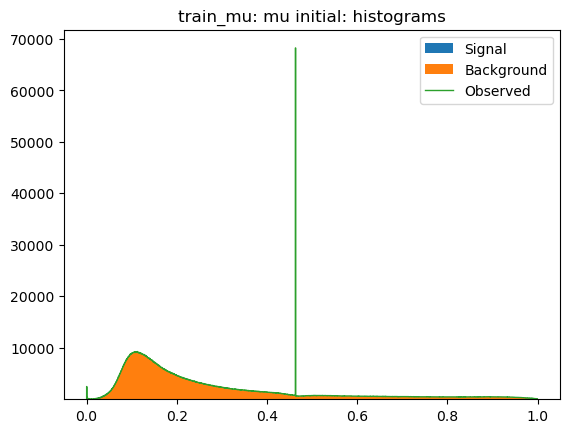

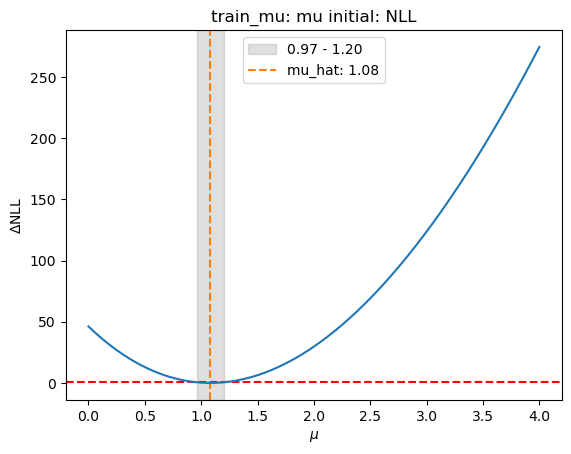

Training Results:
-------- Results:
	mu_hat : 1.0821082108210822
	delta_mu_hat : 0.2324232423242324
	p16 : 0.9660966096609661
	p84 : 1.1985198519851985


20/20 [==============================] - 1s 44ms/step


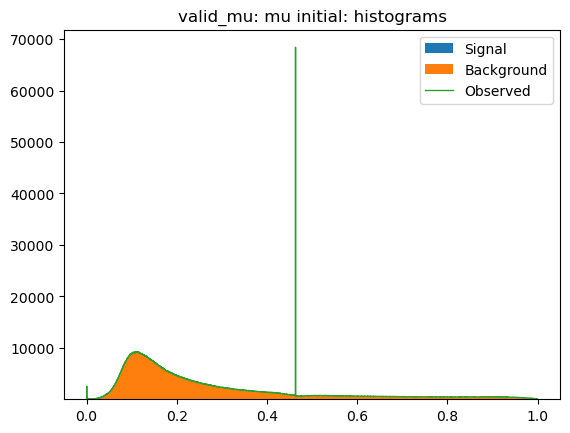

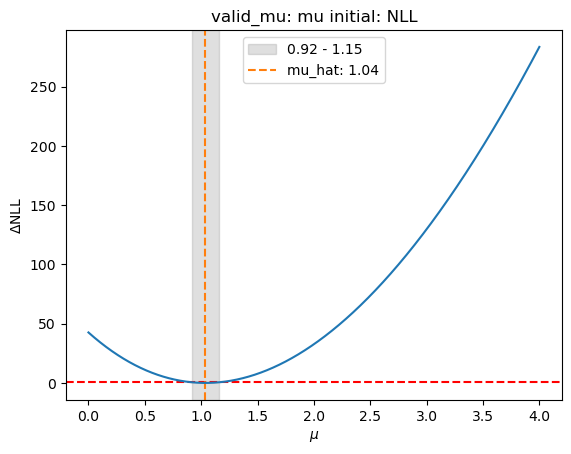

Validation Results:
---------- Results:
	mu_hat : 1.038103810381038
	delta_mu_hat : 0.23162316231623148
	p16 : 0.9224922492249226
	p84 : 1.154115411541154


20/20 [==============================] - 1s 43ms/step


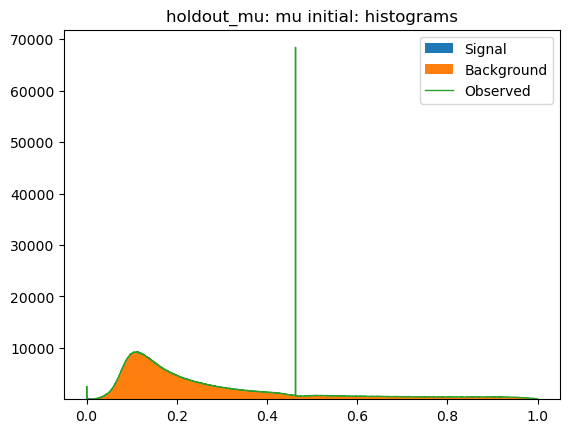

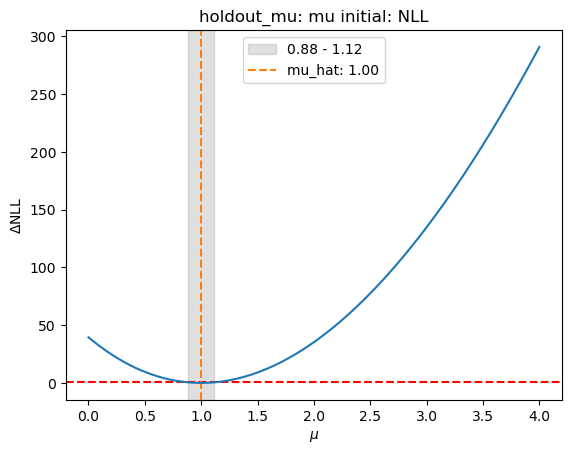

Holdout Results:
------- Results:
	mu_hat : 1.0001000100010002
	delta_mu_hat : 0.2316231623162317
	p16 : 0.8844884488448845
	p84 : 1.1161116111611162


17/17 [==============================] - 1s 45ms/step


In [15]:

# fit submission
ingestion.fit_submission()

In [16]:
ingestion.model.stat_analysis.nominal_histograms(1, apply_syst=True)

17/17 [==============================] - 1s 45ms/step


In [17]:

# load test set
data.load_test_set()

[*] Loading Test data
[+] Test data loaded successfully


In [18]:

# predict submission
ingestion.predict_submission(test_settings)

[*] Calling predict method of submitted model


TypeError: get_bootstrapped_dataset() got an unexpected keyword argument 'lhc_frac'

In [ ]:
ingestion.compute_result()

In [ ]:

# save result
ingestion.save_result(output_dir)

***
# Likelihood plots
***

In [15]:
from tqdm import tqdm

from systematics import postprocess, systematics
from pathlib import Path
# from systematics import LHC_NUMBERS as LHC_NUMBERS_NEW

In [16]:
def NLL(mu, observed, expected_sig, expected_bkgd, scale=1, epsilon=1e-30):
    # need to double check the scaling
    expected = scale * (mu * expected_sig + expected_bkgd)
    return np.sum(expected - observed * np.log(expected + epsilon))

In [17]:
def NLLarray(mus, observed, expected_sig, expected_bkgd, epsilon=1e-30):
    expected = (mus[:, None] * expected_sig + expected_bkgd)
    return (expected - observed * np.log(expected + epsilon)).sum(axis=1)

In [18]:
def get_results(mus, nlls):
    mu_hat = mus[np.argmin(nlls)]
    one_sigma = mus[(nlls - np.min(nlls)) < 0.5]
    return mu_hat, (one_sigma[0], one_sigma[-1])

In [19]:
# check sum of weights after post-cuts
def check_weights_post_syst(data):
    syst_data = systematics(data)
    counts = {
        name: syst_data['weights'][syst_data['detailed_labels'] == name].sum() for name in counts_df.index
    }
    return pd.Series(counts)

In [20]:
def format_test_as_train(data_set=None):
    if data_set is None:
        data.load_test_set()
        data_set = data.get_test_set()
    for name in data_set:
        data_set[name]['detailed_labels'] = name
        data_set[name]['labels'] = 1. if name == 'htautau' else 0.
    joined_data = pd.concat(data_set.values(), axis=0, ignore_index=True, copy=False)
    separated_data = {
        'data': joined_data.drop(columns=['labels', 'detailed_labels', 'weights']),
        'labels': joined_data['labels'],
        'weights': joined_data['weights'],
        'detailed_labels': joined_data['detailed_labels'],
    }
    return separated_data

In [21]:
num_bins = 1
hist_bins = np.linspace(0, 1, num_bins+1)

In [70]:

mus = np.linspace(-9, 11, 10**4) # negtive mu breaks when using labels in place of scores

In [23]:
LHC_NUMBERS = {
    "ztautau": 3544019,
    "diboson": 40590,
    "ttbar": 158761,
    "htautau": 3639,
}

20/20 [==============================] - 1s 44ms/step


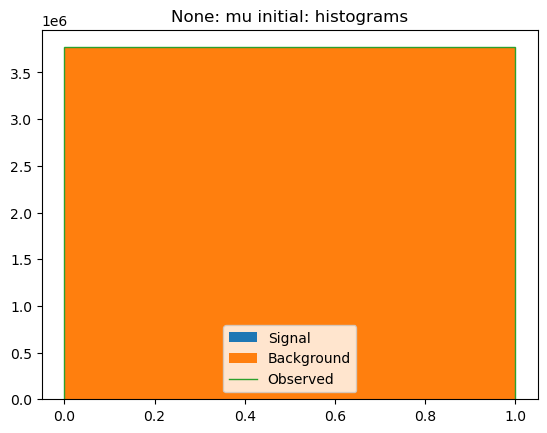

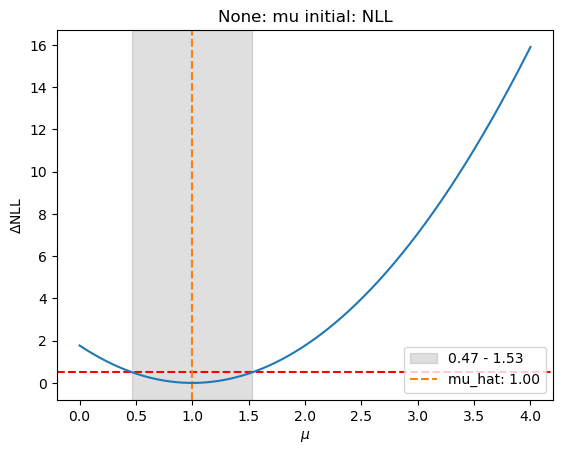

20/20 [==============================] - 1s 44ms/step


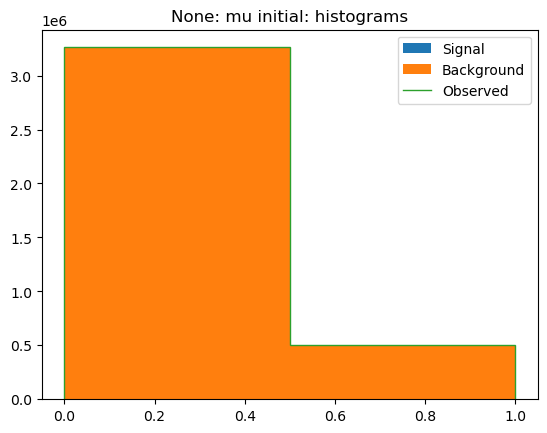

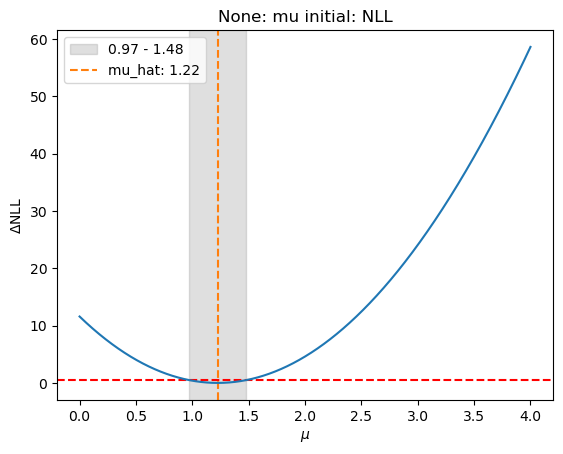

20/20 [==============================] - 1s 44ms/step


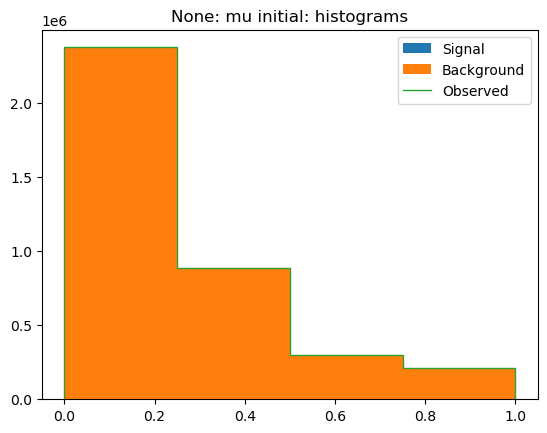

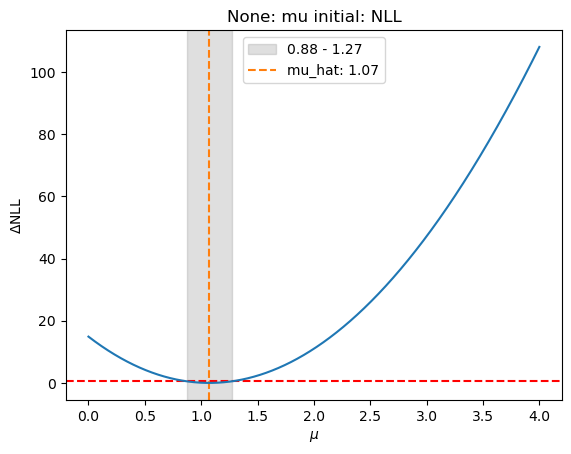

20/20 [==============================] - 1s 43ms/step


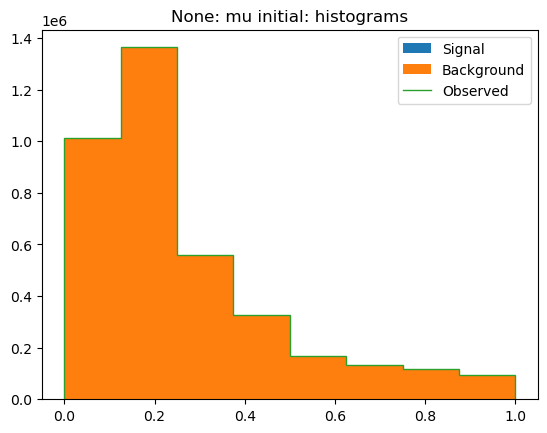

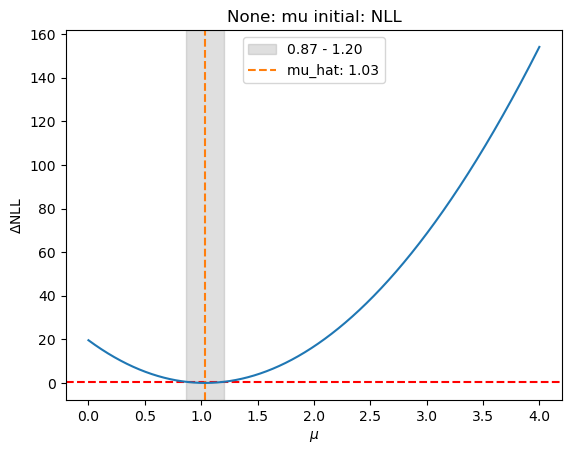

20/20 [==============================] - 1s 44ms/step


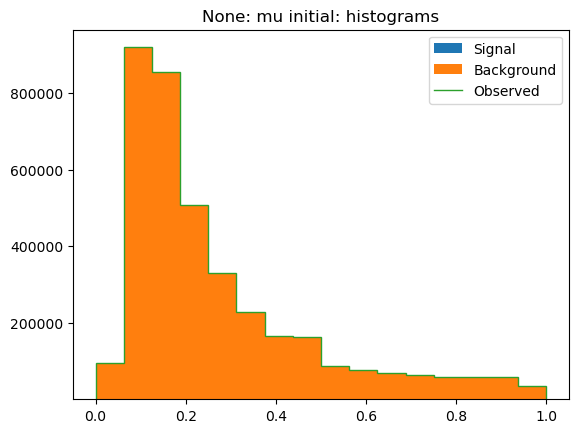

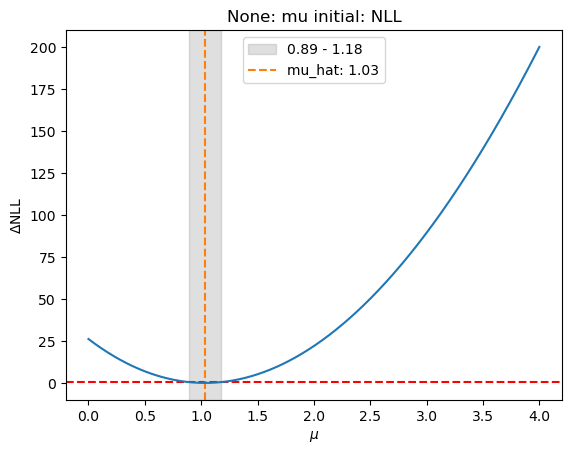

20/20 [==============================] - 1s 44ms/step


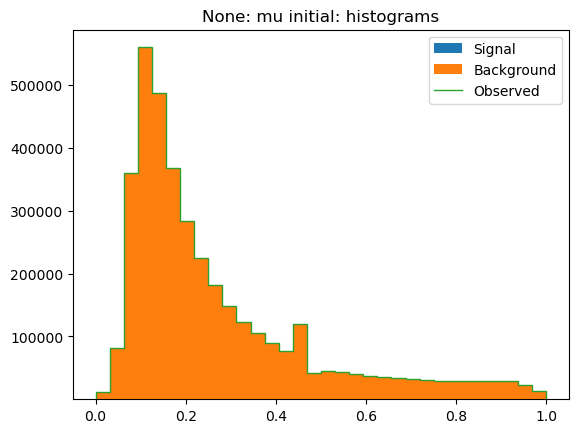

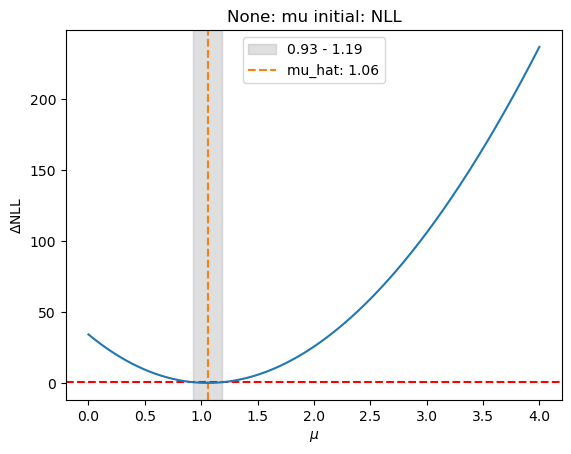

20/20 [==============================] - 1s 43ms/step


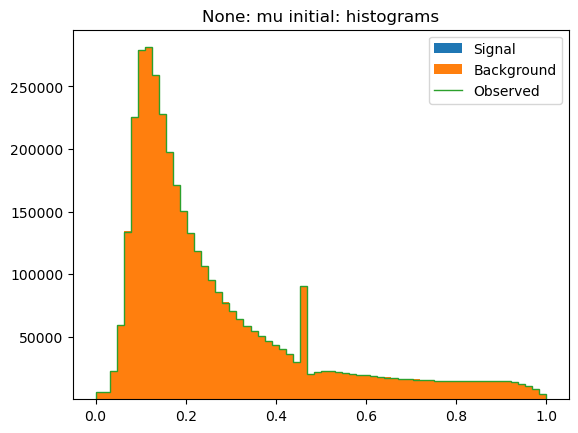

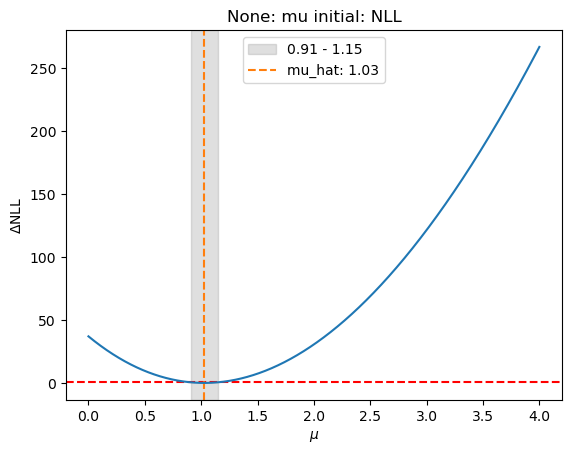

20/20 [==============================] - 1s 44ms/step


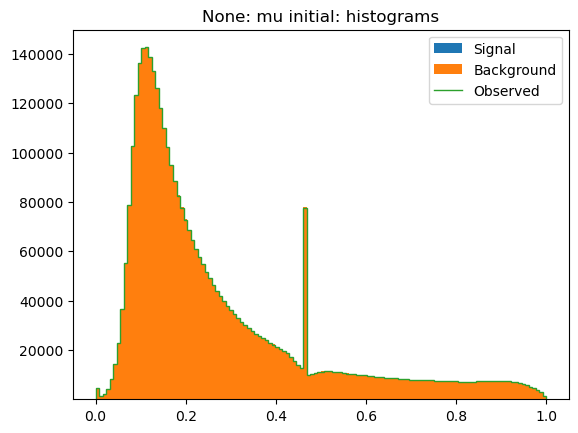

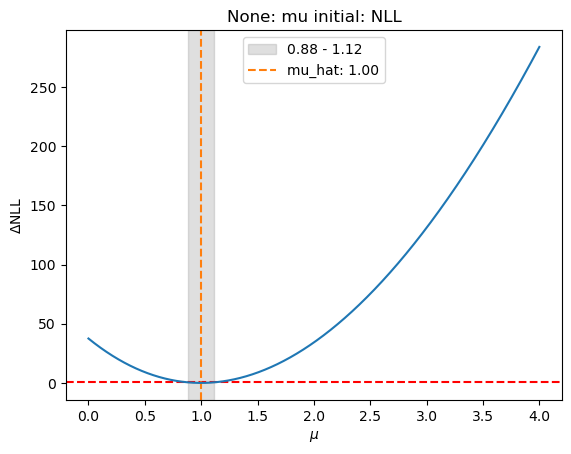

20/20 [==============================] - 1s 43ms/step


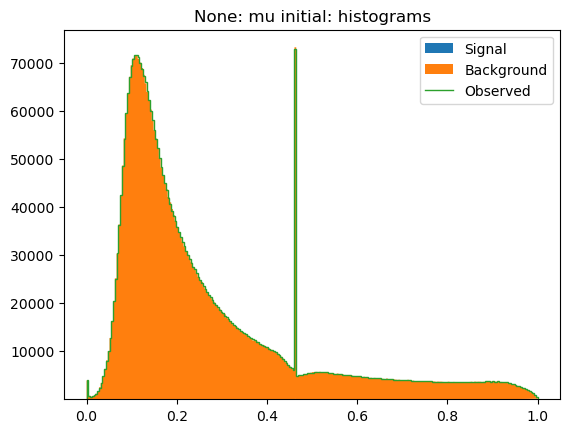

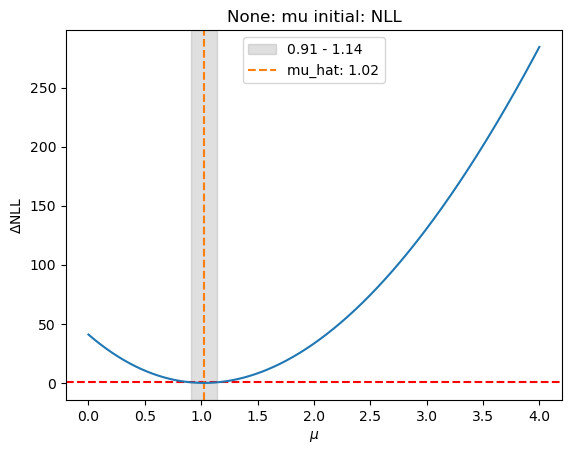

20/20 [==============================] - 1s 44ms/step


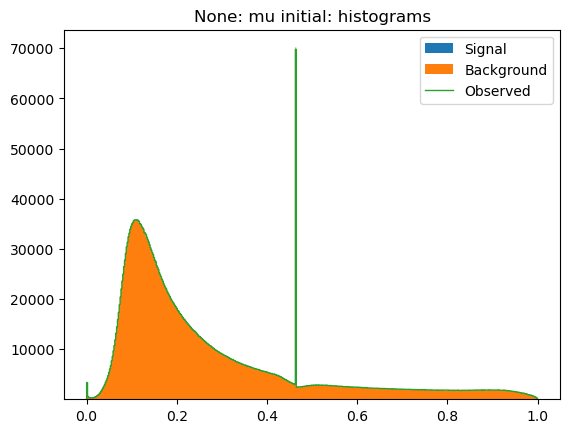

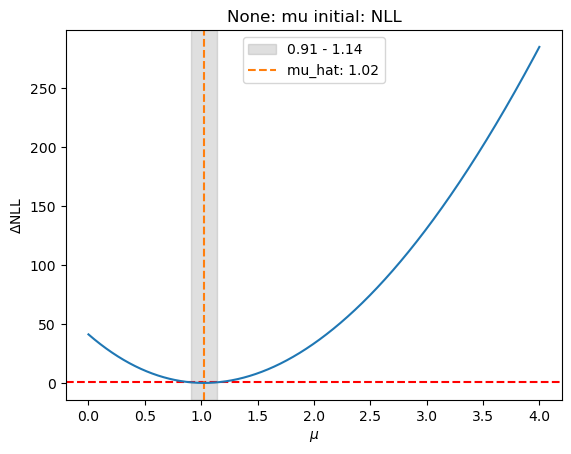

20/20 [==============================] - 1s 44ms/step


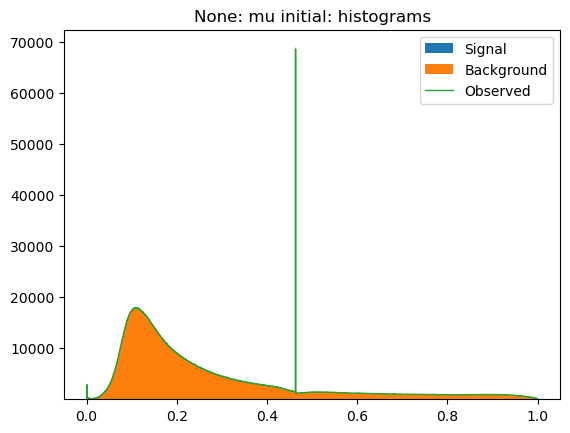

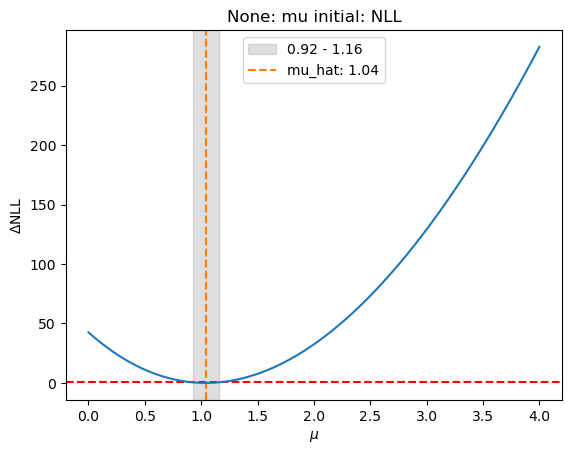

In [26]:
tmp_results = ingestion.model.stat_analysis.vary_hist_bins(
    data_set=format_test_as_train(data.get_test_set()),
)

Text(0.5, 1.0, 'Full test set without cuts')

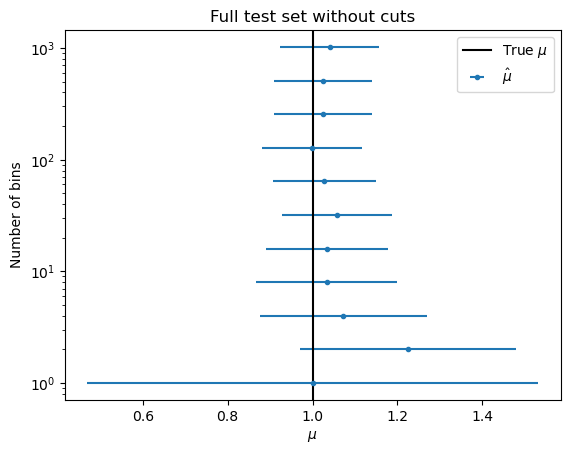

In [38]:
plt.errorbar(
    [result['prediction']['mu_hat'] for result in tmp_results],
    [result['bins'] for result in tmp_results],
    xerr=[result['prediction']['delta_mu_hat'] / 2 for result in tmp_results],
    fmt='.',
    label='$\hat \mu$'
)
plt.axvline(1, color='black', label='True $\mu$')
# plt.axvline(np.mean([result['prediction']['mu_hat'] for result in tmp_results]), color='red', label='Mean $\hat \mu$')
# plt.axvspan(
#     np.mean([result['prediction']['mu_hat'] for result in tmp_results]) - np.std([result['prediction']['mu_hat'] for result in tmp_results]) / np.sqrt(len(tmp_results)),
#     np.mean([result['prediction']['mu_hat'] for result in tmp_results]) + np.std([result['prediction']['mu_hat'] for result in tmp_results]) / np.sqrt(len(tmp_results)),
#     color='red',
#     alpha=0.2,
#     label='$ 1 \sigma $'
# )
plt.xlabel('$\mu$')
plt.ylabel('Number of bins')
plt.yscale('log')
plt.legend()
plt.title('Full test set without cuts')

17/17 [==============================] - 1s 45ms/step


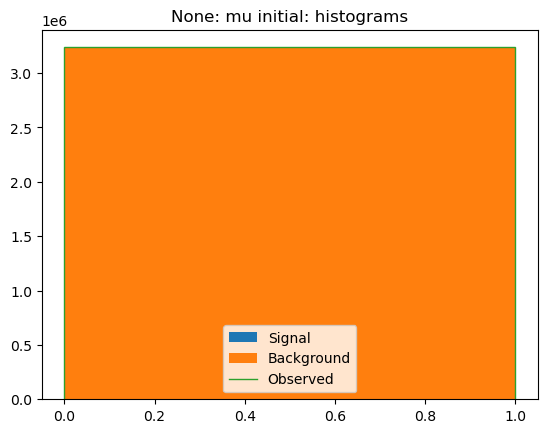

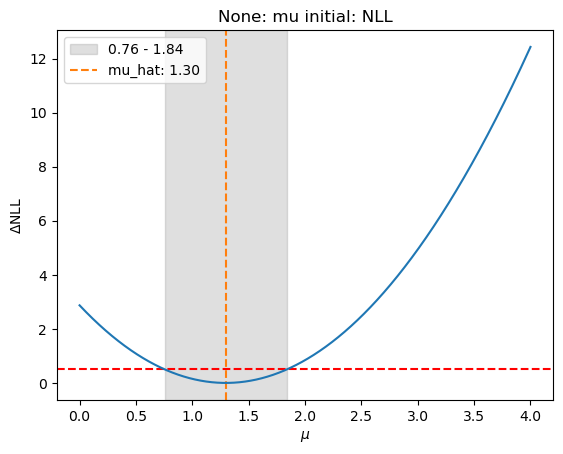

17/17 [==============================] - 1s 46ms/step


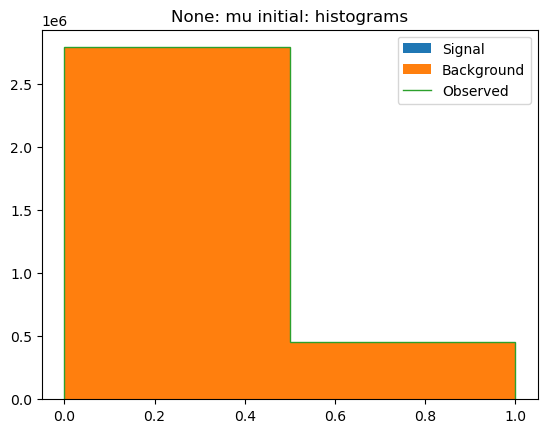

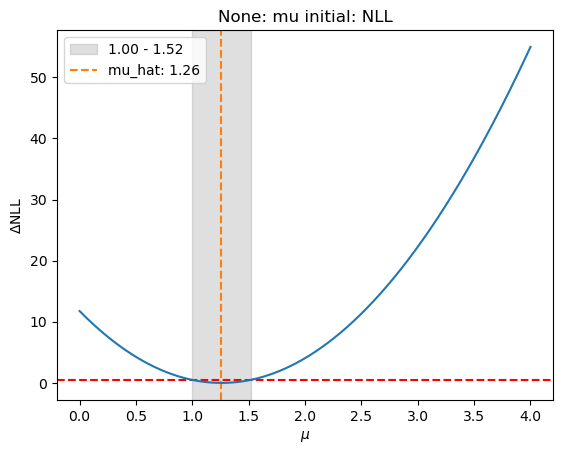

17/17 [==============================] - 1s 46ms/step


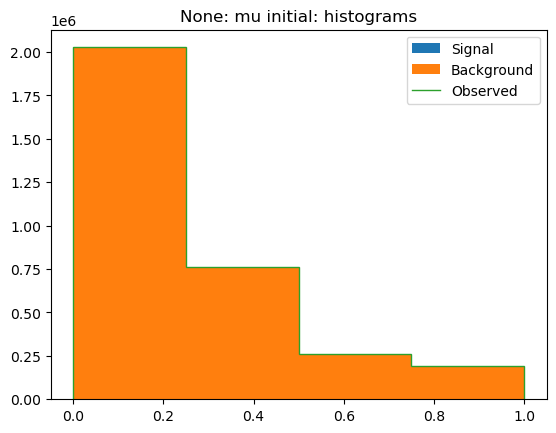

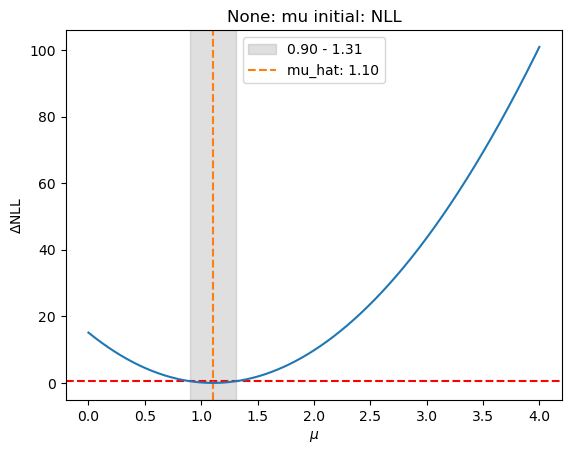

17/17 [==============================] - 1s 46ms/step


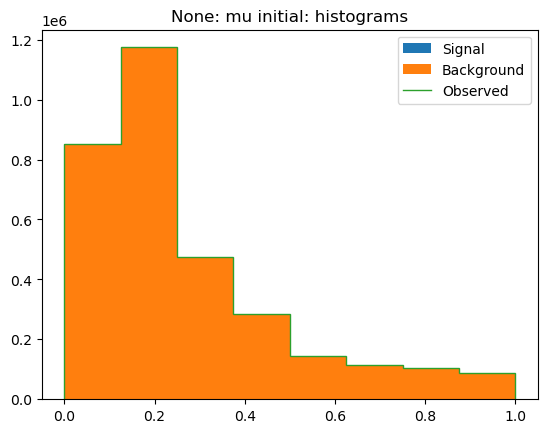

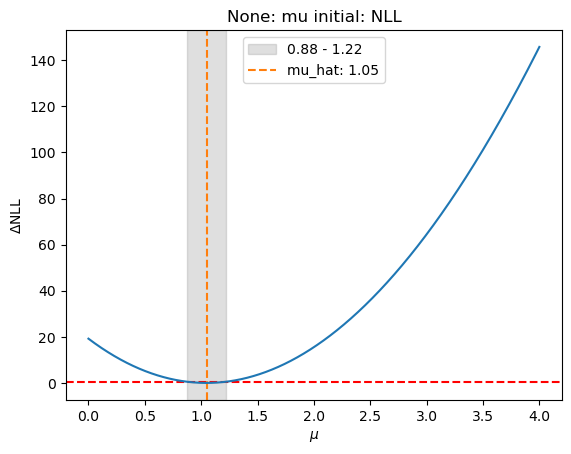

17/17 [==============================] - 1s 45ms/step


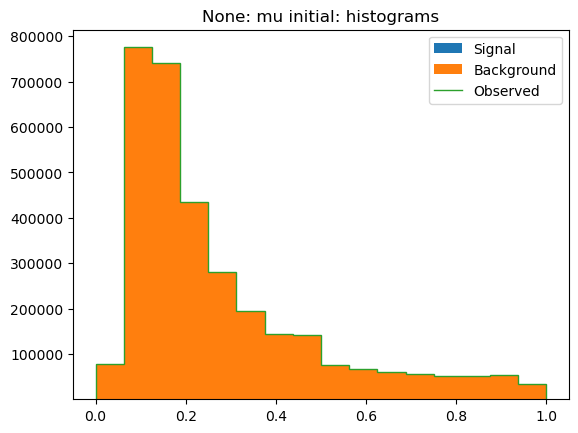

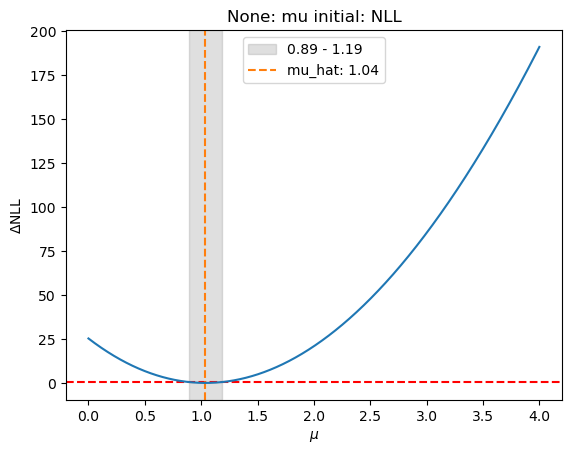

17/17 [==============================] - 1s 46ms/step


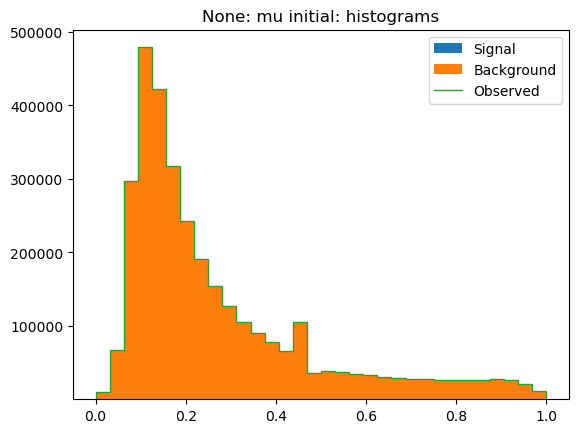

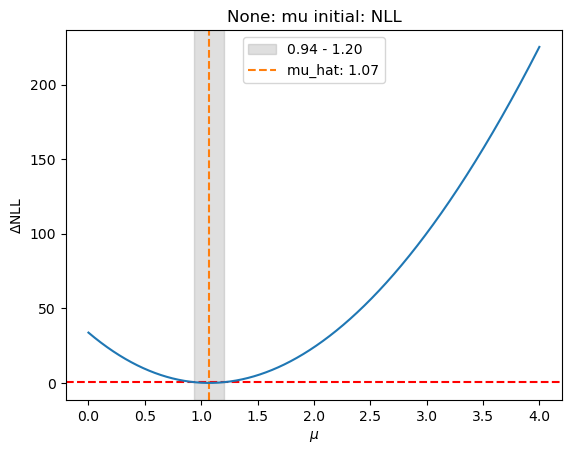

17/17 [==============================] - 1s 45ms/step


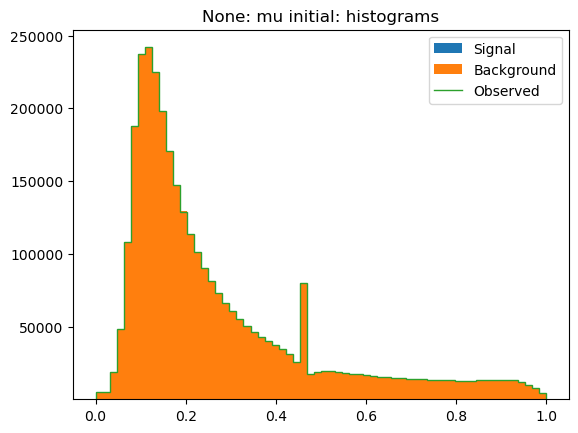

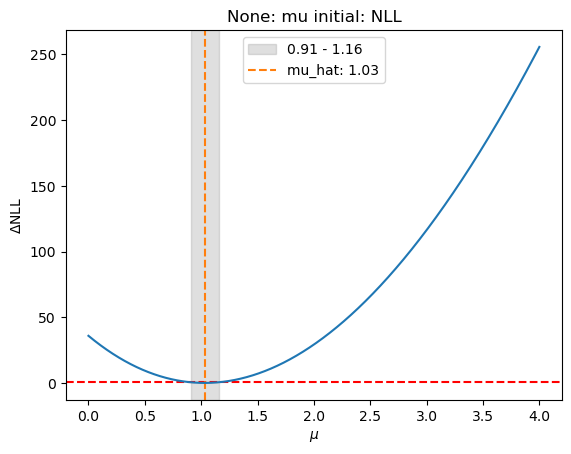

17/17 [==============================] - 1s 45ms/step


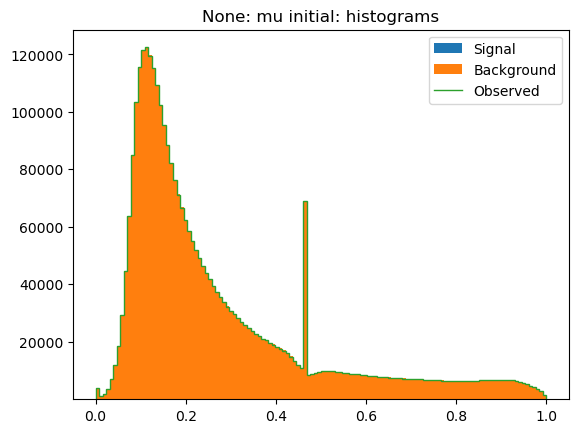

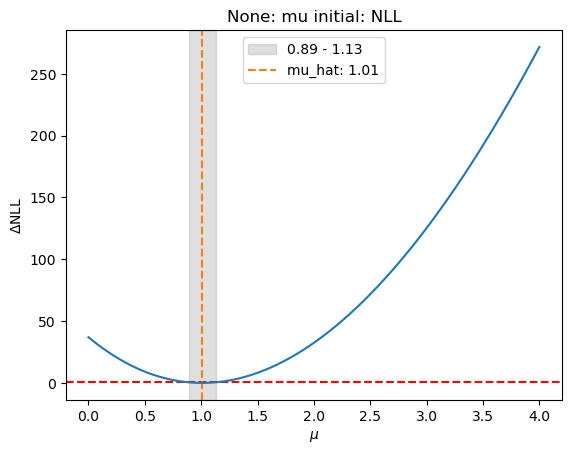

17/17 [==============================] - 1s 46ms/step


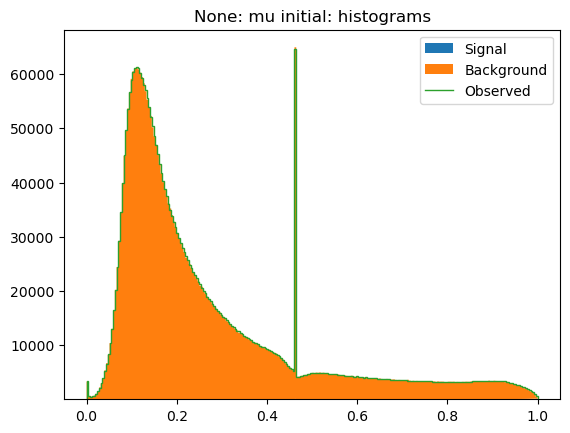

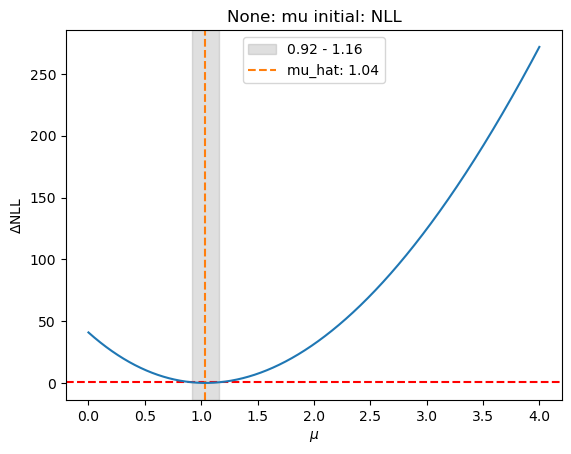

17/17 [==============================] - 1s 45ms/step


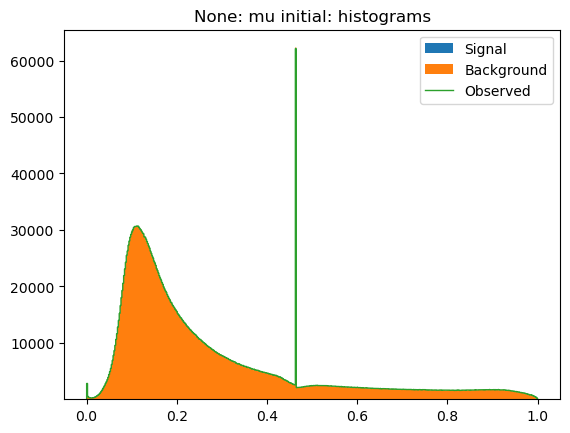

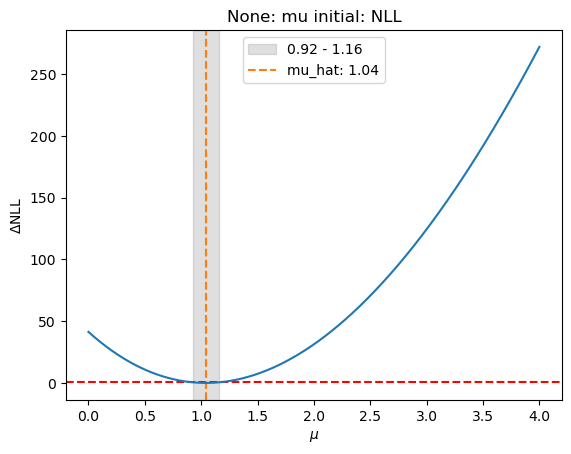

17/17 [==============================] - 1s 45ms/step


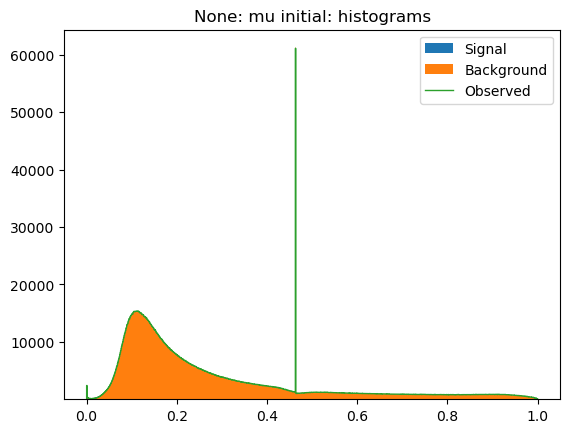

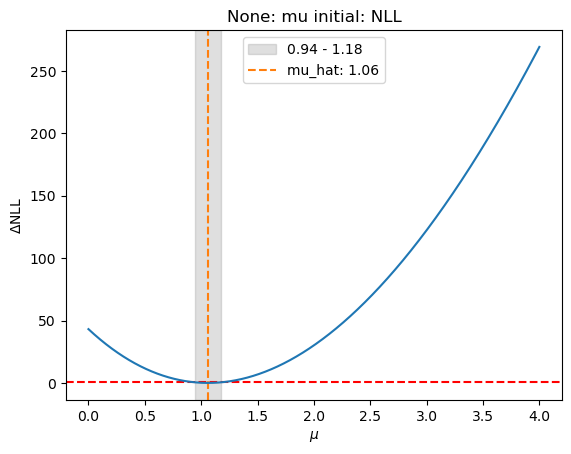

In [35]:
tmp_results_syst = ingestion.model.stat_analysis.vary_hist_bins(
    data_set=format_test_as_train(data.get_test_set()),
    apply_syst=True,
)

Text(0.5, 1.0, 'Full test set with cuts')

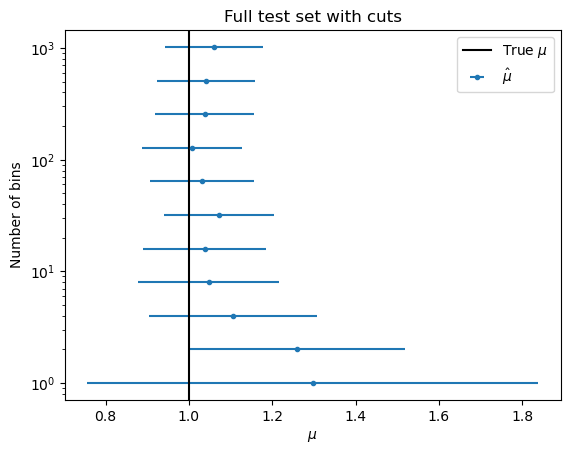

In [36]:
plt.errorbar(
    [result['prediction']['mu_hat'] for result in tmp_results_syst],
    [result['bins'] for result in tmp_results_syst],
    xerr=[result['prediction']['delta_mu_hat'] / 2 for result in tmp_results_syst],
    fmt='.',
    label='$\hat \mu$'
)
plt.axvline(1, color='black', label='True $\mu$')
plt.xlabel('$\mu$')
plt.ylabel('Number of bins')
plt.yscale('log')
plt.legend()
plt.title('Full test set with cuts')

## Checking event counts

In [23]:
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79886911 entries, 0 to 79886910
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(28)
memory usage: 8.3 GB
None
[+] Train data loaded successfully


In [24]:
all_weighted_data = data.get_train_set().copy()

In [25]:
for k, v in all_weighted_data.items():
    print(k, type(v))

data <class 'pandas.core.frame.DataFrame'>
labels <class 'numpy.ndarray'>
settings <class 'dict'>
weights <class 'numpy.ndarray'>
detailed_labels <class 'list'>


In [26]:
all_weighted_data['detailed_labels'] = np.array(all_weighted_data['detailed_labels'])

ztautau (35821299,) 0.10031166737650216 1.0547118733938987e-15
0.100312    35821299
Name: count, dtype: int64
diboson (136129,) 0.10000175763087524 0.008715854006921958
0.098965    110647
0.117534     17625
0.075272      7857
Name: count, dtype: int64
ttbar (1590109,) 0.10000010220335974 0.00045422451268948156
0.100110    1346931
0.099282     177824
0.100108      61179
0.095367       3097
0.088220       1077
0.159624          1
Name: count, dtype: int64
htautau (42339374,) 8.629825994442772e-05 2.2758403511046853e-07
0.000086    33193225
0.000086     3667918
0.000086     1620879
0.000086     1400532
0.000086     1154964
0.000087      743835
0.000086      394720
0.000088      162057
0.000069        1244
Name: count, dtype: int64


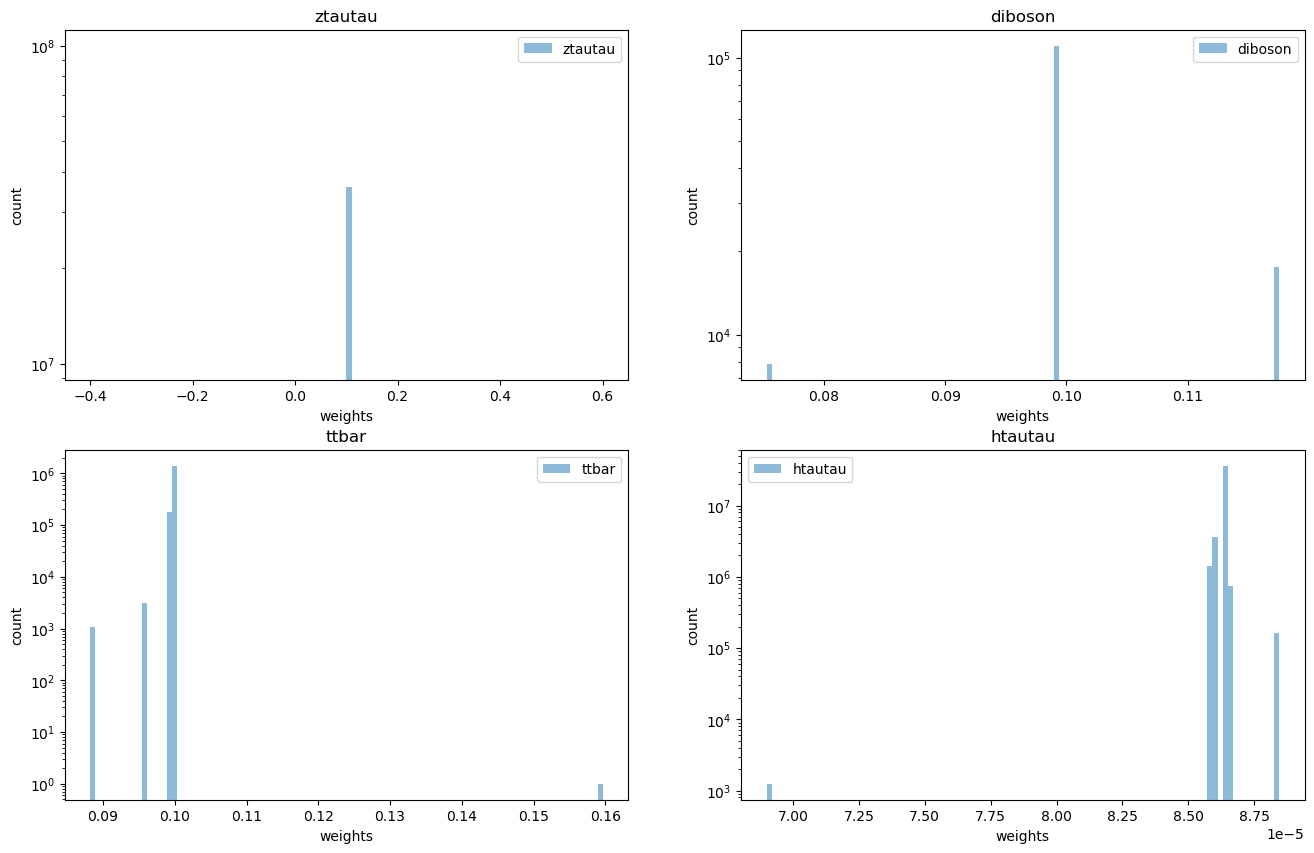

In [27]:
# {name: all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name] for name in LHC_NUMBERS}
# plt.figure(figsize=(16, 10))
plt.subplots(2, 2, figsize=(16, 10))
for j, name in enumerate(LHC_NUMBERS, start=1):
    plt.subplot(2, 2, j)
    tmp_weights = all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name]
    print(name, tmp_weights.shape, tmp_weights.mean(), tmp_weights.std())
    print(pd.Series(tmp_weights).value_counts())
    plt.hist(tmp_weights, bins=100, density=False, alpha=0.5, label=name)
    plt.title(name)
# plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('weights')
    plt.ylabel('count')
    plt.legend()
# plt.title('weighted data')


In [28]:
(all_weighted_data['weights'][all_weighted_data['detailed_labels'] == 'htautau'] == 0).sum(), (all_weighted_data['detailed_labels'] == 'htautau').sum()

(0, 42339374)

In [29]:
counts_df = pd.DataFrame.from_dict(
    {
        name: {
            'LHC_NUMBERS (old)': LHC_NUMBERS[name],
            'sum of weights': all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name].sum(),
            'num weighted events': (all_weighted_data['detailed_labels'] == name).sum(),
            'average weight': all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name].mean(),
        }
        for name in LHC_NUMBERS
    },
    orient='index',
)

In [30]:
counts_df.T.style.format(precision=6)

,ztautau,diboson,ttbar,htautau
LHC_NUMBERS (old),3544019.000000,40590.000000,158761.000000,3639.000000
sum of weights,3593294.230282,13613.139265,159011.062514,3653.814303
num weighted events,35821299.000000,136129.000000,1590109.000000,42339374.000000
average weight,0.100312,0.100002,0.100000,0.000086


In [31]:
counts_df

,LHC_NUMBERS (old),sum of weights,num weighted events,average weight
ztautau,3544019,3.593294e+06,35821299,0.100312
diboson,40590,1.361314e+04,136129,0.100002
ttbar,158761,1.590111e+05,1590109,0.100000
htautau,3639,3.653814e+03,42339374,0.000086


In [42]:
counts_df['train_post'] = check_weights_post_syst(data.get_train_set())
counts_df['test_post'] = check_weights_post_syst(format_test_as_train(data.get_test_set()))

In [55]:
counts_df[['train_post', 'test_post']].assign(diff=lambda df: df['test_post'] - df['train_post']).T.assign(sum=lambda df: df.sum(1)).style.format(precision=3)

,ztautau,diboson,ttbar,htautau,sum
train_post,3074033.693,11805.536,147966.606,3322.679,3237128.513
test_post,3074167.494,11813.411,148008.180,3307.398,3237296.483
diff,133.801,7.875,41.575,-15.281,167.970


## Comparison

Use scores and weights from Sascha

In [ ]:
bresult = [] # list of dictionaries of results of varying num_bins

In [ ]:
sresults = {}

In [ ]:
# sascha_dir = Path('/global/ml4hep/spss/jvdudley/physicsData/FairUniverse/comparison_Sascha/Fair_Universe_Comparison_Data/')
sascha_dir = Path('/global/ml4hep/spss/sdiefenbacher/Fair_Universe/comparison/comparison_templates_data_07_23_seed45/')
# sprefix = 'Run_9'

In [ ]:
for file in sascha_dir.glob('eval*.npy'):
    # if file.stem.startswith('Run'): continue
    print(file.stem)

In [ ]:
def sread(pattern, dir=sascha_dir):
    return {file.stem: np.load(file) for file in dir.glob(pattern)}

In [ ]:
sread('eval*.npy')

In [ ]:
sread('Run_0*.npy')

In [ ]:
for pattern in ('eval*.npy', 'Run_0*.npy', '*bkg*.npy'):
    plt.hist()

In [ ]:
stdata = {}
sedata = {}

sdata = {}

In [ ]:
# for pattern in ('*sig*.npy', '*bkg*.npy', '*Run_*.npy'):
for name, data in sread('*.npy').items():
    # print(name, data.shape)
    if name.endswith('_weights'):
        tmpsuffix = 'weights'
    elif name.endswith('_values'):
        tmpsuffix = 'values'
    else:
        raise ValueError(f'{name} does not end with "_weights" or "_values"')
    tmpprefix = name.removesuffix('_weights').removesuffix('_values')
    if tmpprefix.startswith('Run_'):
        tmpprefix = int(tmpprefix.removeprefix('Run_').removesuffix('eval'))
    if tmpprefix not in sdata:
        sdata[tmpprefix] = {}
    sdata[tmpprefix][tmpsuffix] = data

In [ ]:
for name, data in sread('*Run_*.npy').items():
    tmpprefix = name.removesuffix('_weights').removesuffix('_values')
    if tmpprefix not in sedata:
        sedata[tmpprefix] = {}
    sedata[tmpprefix][name.removeprefix(tmpprefix + '_')] = data

In [ ]:
sedata['Run_0eval'].keys()

In [ ]:
sascha_copy = {file.stem: np.load(file) for file in sascha_dir.glob('*bkg*.npy')}
sascha_data = {}


In [ ]:
for name in sascha_copy:
    tmp_prefix = name.removesuffix('_values').removesuffix('_weights')
    if tmp_prefix not in sascha_data:
        sascha_data[tmp_prefix] = {}
    sascha_data[tmp_prefix][name.removeprefix(tmp_prefix + '_')] = sascha_copy[name]
del sascha_copy

In [ ]:
sascha_hist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in sascha_data.items()}

In [ ]:
shist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in tqdm(sdata.items())}

In [ ]:
svar = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights']**2)[0] for name, data in tqdm(sdata.items())}

In [ ]:
sthist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in stdata.items()}
sehist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in sedata.items()}

In [ ]:
(np.sqrt(shist['template_sig'] + shist['template_bkg']) / np.sqrt((svar['template_sig'] + svar['template_bkg']))).min()

In [ ]:
plt.stairs(
    np.sqrt(shist['template_sig'] + shist['template_bkg']),
    hist_bins,
    label='Poisson uncertainty',
    # color='blue',
    alpha=0.5,
    fill=True,
)
plt.stairs(
    np.sqrt(svar['template_sig'] + svar['template_bkg']),
    hist_bins,
    label='MC uncertainty',
    # color='red',
    alpha=0.5,
    fill=True,
)
plt.legend()

In [ ]:
plt.figure(figsize=(12, 10))
plt.axvline(
    hist_bins[shist['template_sig'].argmax()] + (hist_bins[1] - hist_bins[0]) / 2,
    color='red',
    linestyle='--',
    label='max sig',
    alpha=0.5,
)
plt.axvline(
    hist_bins[(shist['template_sig'] / shist['template_bkg']).argmax()] + (hist_bins[1] - hist_bins[0]) / 2,
    color='red',
    linestyle=':',
    label='max sig/bkg',
    alpha=0.5,
)
# plt.hist(
#     [hist_bins[:-1],] * 2,
#     hist_bins,
#     weights=[hist for name, hist in shist.items() if isinstance(name, str)],
#     alpha=0.5,
#     label=[name for name in shist if isinstance(name, str)],
#     histtype='barstacked',
# )
# tmp_vals = 0
# tmp_baseline = 0
# for sb in ('template_bkg', 'template_sig'):
#     tmp_vals += shist[sb]
#     plt.stairs(
#         tmp_vals,
#         hist_bins,
#         alpha=0.5,
#         label=sb,
#         baseline=tmp_baseline,
#         fill=True,
#     )
#     tmp_baseline += shist[sb]
plt.stairs(
    shist['template_sig'],
    hist_bins,
    alpha=0.5,
    label='sig',
    fill=True,
)
plt.errorbar(
    (hist_bins[:-1] + hist_bins[1:]) / 2,
    shist['template_sig'], # + shist['template_bkg']
    1 * np.sqrt(svar['template_sig'] + svar['template_bkg']),
    fmt=',',
    color='black',
    # drawstyle='steps-mid',
    label='bkg+sig uncertainty',
    alpha=0.5,
)
for name, hist in shist.items():
    if isinstance(name, str):
        continue
    plt.stairs( # hist(
        hist - shist['template_bkg'], # hist_bins[:-1],
        hist_bins,
        # weights=hist - shist['template_bkg'],
        alpha=0.01,
        # label=name,
        # histtype='step',
    )
# plt.yscale('log')
# plt.xlim(.9, 1)
# plt.ylim(4e1, 1.3e3)
plt.grid()
plt.legend()
plt.title('pseudoexperiments - bkg template')

In [ ]:
sascha_data.keys()

In [ ]:
# sascha_nlls = [
#     NLL(
#         mu,
#         sascha_hist[sprefix + 'eval'],
#         sascha_hist[sprefix + 'template_sig'],
#         sascha_hist[sprefix + 'template_bkg'],
#     ) for mu in mus
# ]
sascha_nlls = NLLarray(
    mus,
    shist[0],
    shist['template_sig'],
    shist['template_bkg'],
)

In [ ]:
sascha_one_sigma = np.array(mus)[(sascha_nlls - min(sascha_nlls)) < 0.5]

In [ ]:
sresults[sprefix] = (sascha_one_sigma[0], sascha_one_sigma[-1])

In [ ]:
plt.plot(mus, sascha_nlls - min(sascha_nlls))
plt.axhline(.5, color='black', linestyle='--')
plt.axvline(mus[np.argmin(sascha_nlls)], color='C1', label=f'mu_hat: {mus[np.argmin(sascha_nlls)]:.2f}')
# plt.axvline(sascha_one_sigma[0], color='r', label=f'p16: {sascha_one_sigma[0]:.2f}')
# plt.axvline(sascha_one_sigma[-1], color='r', label=f'p84: {sascha_one_sigma[-1]:.2f}')
plt.axvspan(sascha_one_sigma[0], sascha_one_sigma[-1], color='grey', alpha=0.5, label=f'p16-p84: {sascha_one_sigma[0]:.2f}-{sascha_one_sigma[-1]:.2f}')
# plt.axvline(1.45, color='C2', label='mu_hat (Sascha)')
# plt.axvline(1.3952, color='C3', label='mu_hat (Yulei)')
plt.axvline(1, color='black', label='mu_true')
# plt.plot(mus, 5.1 * (mus - mus[np.argmin(sascha_nlls)])**2, label='(mu - mu_hat)^2')
plt.ylim(0, 2)
plt.xlabel('mu')
plt.ylabel('NLL - min(NLL)')
plt.legend()
plt.title('Comparison:' + sprefix)

In [ ]:
sresults = {}

In [ ]:
for name, hist in tqdm(shist.items(), 'computing results from histograms'):
    # print(name)
    if isinstance(name, str):
        continue
    snlls = NLLarray(mus, hist, shist['template_sig'], shist['template_bkg'])
    #     NLL(
    #         mu,
    #         hist,
    #         shist['template_sig'],
    #         shist['template_bkg'],
    #     ) for mu in mus
    # ]
    sresults[name] = get_results(mus, snlls)

In [ ]:
intervals = np.array([t for _, t in sresults.values()])

In [ ]:
assert mus[1] < intervals.min(), f'mus starts too high'
print(f'{mus[1]:.3f} < {intervals.min():.3f}')
assert mus[-2] > intervals.max(), f'mus ends too low'
print(f'{mus[-2]:.3f} > {intervals.max():.3f}')


In [ ]:
# bresult[num_bins] = (intervals.mean(), ((intervals[:, 0] < 1) & (intervals[:, 1] > 1)).mean())
bresult.append({
    'mean': intervals.mean(),
    'stderr': intervals.mean(1).std() / np.sqrt(intervals.shape[0]),
    'coverage': ((intervals[:, 0] < 1) & (intervals[:, 1] > 1)).mean(),
    'num_pseudo_experiments': intervals.shape[0],
    'num_bins': num_bins,
})

# print(f'mean: {bresult[num_bins][0]:.3f}, coverage: {bresult[num_bins][1]:.3f}')
print(bresult[-1])

In [ ]:
plt.figure(figsize=(12, 10))
plt.hlines(
    [name for name in sresults],
    [p16 for _, (p16, _) in sresults.values()],
    [p84 for _, (_, p84) in sresults.values()],
)
# plot mu_true: currently 1
plt.axvline(1, color='black', label=f'mu_true=1')
# plot mu_hat mean
plt.axvline(bresult[-1]['mean'], color='r', label=f'mu_hat mean={bresult[-1]["mean"]:.3f}')
# plot mu_hat stderr
plt.axvspan(
    bresult[-1]['mean'] - bresult[-1]['stderr'],
    bresult[-1]['mean'] + bresult[-1]['stderr'],
    color='r',
    alpha=0.25,
    label=f'mu_hat stderr={bresult[-1]["stderr"]:.3f}',
)
plt.xlabel('mu')
plt.ylabel('pseudo-experiment')
plt.title(f'{num_bins} histogram bins: coverage={bresult[-1]["coverage"]:.3f}')
plt.legend()

In [ ]:
# bresult plots of mean±stderr and coverage vs num_bins
fig = plt.figure(figsize=(12, 10))
plt.errorbar(
    [b['mean'] for b in bresult],
    [b['num_bins'] for b in bresult],
    xerr=[b['stderr'] for b in bresult],
    fmt='o',
    label='mu_hat',
    alpha=0.5,
)
plt.axvline(1, color='black', label='mu_true')
plt.yscale('log')
plt.ylabel('num_bins')
plt.xlabel('mu_hat')
plt.twiny()
plt.errorbar(
    [b['coverage'] for b in bresult],
    [b['num_bins'] for b in bresult],
    xerr=[np.sqrt(.682689 * (1 - .682689) / b['num_pseudo_experiments']) for b in bresult],
    fmt='ro',
    label='coverage',
    alpha=0.5,
)
plt.axvline(.682689, color='r', linestyle='--', label='1 sigma')
# plt.axhspan(
#     .682689 - np.sqrt(.682689 * (1 - .682689) / bresult[-1]['num_pseudo_experiments']),
#     .682689 + np.sqrt(.682689 * (1 - .682689) / bresult[-1]['num_pseudo_experiments']),
#     color='grey',
#     alpha=0.25,
# )
plt.xlabel('coverage')
plt.suptitle('Results of varying num_bins')
plt.text(.557, .9, sascha_dir.stem)
fig.legend()

In [ ]:
cresults = {
    'Jordan': {
        'Run_0': (0.8823613236132362, 1.1882118821188212),
        'Run_1': (0.8945064450644507, 1.1997444974449745),
        'Run_2': (0.8033480334803348, 1.115131151311513),
        'Run_3': (0.9987899878998789, 1.3043430434304342),
        'Run_4': (0.9687946879468795, 1.2695876958769587),
        'Run_5': (0.9235392353923539, 1.232959829598296),
        'Run_6': (1.180021800218002, 1.4898273982739827),
        'Run_7': (1.091540915409154, 1.4003315033150332),
        'Run_8': (1.0722382223822238, 1.378928789287893),
        'Run_9': (1.0410879108791087, 1.3475684756847568),
    },
    'Sascha': {
        'Run_0': (0.901194159732266, 1.2062761636214896),
        'Run_1': (0.8894361103293542, 1.1950205736920794),
        'Run_2': (0.8156946813859971, 1.1266712540266663),
        'Run_3': (0.9982769846663299, 1.3037225824265635),
        'Run_4': (0.9674725796855451, 1.2681422564378708),
        'Run_5': (0.9341876695842286, 1.2431236399605807),
        'Run_6': (1.210834505642529, 1.5191684157141783),
        'Run_7': (1.1024395216920113, 1.4106339865777082),
        'Run_8': (1.0826025589257644, 1.388693180595792),
        'Run_9': (1.0624547927260337, 1.3678220195383683),
    },
    'Yulei': [
        (0.8641240477713032, 1.1685347528269672),
        (0.8534984694263906, 1.1566380803920224),
        (0.8163559424937542, 1.1282676529144529),
        (1.0138248845573359, 1.3189941669186172),
        (0.9976235681984136, 1.2983202394845823),
        (0.8384660075098151, 1.145517502230531),
        (1.0601399318867162, 1.3669774991943608),
        (1.0648479946635852, 1.3725732313530639),
        (1.1072575393906805, 1.4142756561289402),
        (0.9287805137600891, 1.2318307738852956),
    ],
}

In [ ]:
cresults['Yulei'] = {f'Run_{j}': vals for j, vals in enumerate(cresults['Yulei'])}

In [ ]:
plt.figure(figsize=(12, 10))
plt.axvline(1, color='black', label='mu_true=1')
for j, (name, results) in enumerate(cresults.items()):
    plt.hlines(
        [int(run.removeprefix('Run_')) + j/10 for run in results],
        [p16 for p16, _ in results.values()],
        [p84 for _, p84 in results.values()],
        color=f'C{j}',
        label=name,
    )
plt.xlabel('mu')
plt.ylabel('Run_[number]')
plt.legend()
plt.title('Coverage comparison')

## Predict mu for test data

This does not include postselection cuts

In [24]:
# read data: train, valid, test
train_set = ingestion.model.training_set.copy()
valid_set = ingestion.model.stat_analysis.holdout_set.copy()
ingestion.data.load_test_set()
test_set = ingestion.data.get_test_set().copy()


[*] Loading Test data
[+] Test data loaded successfully


In [25]:
pseudo_exp_data = ingestion.data.generate_pseudo_exp_data(seed=3141592653)

In [26]:
assert (pseudo_exp_data['weights'] == 1).all(), 'pseudo experiment data weights are not all one'

In [ ]:
counts_df['num unweighted events'] = {name: df.shape[0] for name, df in data.get_test_set().items()}

In [ ]:
counts_df.T.style.format(precision=3, thousands=',').format(precision=6, subset=('average weight',))

In [ ]:
sums_by_type = {
    name: (
        # all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name].sum(),
        train_set['weights'][train_set['detailed_labels'] == name].sum(),
        valid_set['weights'][valid_set['detailed_labels'] == name].sum(),
    )
    for name in LHC_NUMBERS
}

In [ ]:
sums_by_type['bkgd'] = (
    all_weighted_data['weights'][all_weighted_data['labels'] == 0].sum(),
    train_set['weights'][train_set['labels'] == 0].sum(),
    valid_set['weights'][valid_set['labels'] == 0].sum(),
)

In [ ]:
for name, sums in sums_by_type.items():
    print(f'{name}:\nall: {sums[0]:.3f}, train: {sums[1]:.3f}, valid: {sums[2]:.3f}')
    print(f'min: {min(sums[1:]):.3f}\nmax: {max(sums[1:]):.3f}')
    # print(min(sums[1:]) < sums[0] < max(sums[1:]))
    if sums[0] < min(sums[1:]):
        print(f'Warning: {name} sum of weights in all data less than in train and valid data')
    elif sums[0] > max(sums[1:]):
        print(f'Warning: {name} sum of weights in all data greater than in train and valid data')
    else:
        print(f'{name} sum of weights in all data is between train and valid data')

In [ ]:
# replace LHC_NUMBERS[name] with counts_df['sum of weights'][name].round().astype(int)

# for key in test_set:
#     print(key, test_set[key].shape)
#     assert test_set[key].shape[0] >= LHC_NUMBERS[key], f'{key} test set is too small'
#     test_set[key] = test_set[key].copy()[:LHC_NUMBERS[key]]
print(data.get_test_set()['htautau'].shape)
test_set_samples = {}
for name, df in test_set.items():
    print(f'{name}: unweighted events={df.shape[0]}, old expectation={LHC_NUMBERS[name]}, ratio={df.shape[0] / LHC_NUMBERS[name]}, new expectation={LHC_NUMBERS_NEW[name]}')
    assert df.shape[0] > LHC_NUMBERS_NEW[name], f'{name} test set is too small'
    test_set_samples[name] = df[:int(LHC_NUMBERS_NEW[name] + .5)]
test_set = test_set_samples
print(data.get_test_set()['htautau'].shape)

In [27]:
valid_syst = systematics(valid_set.copy())

In [28]:
valid_syst['weights'].sum(), pseudo_exp_data['weights'].sum(), sum((df.shape[0] for df in test_set.values()))

(3236309.398495829, 3242314.0, 18792037)

In [29]:
valid_set = valid_syst

In [30]:
for name in test_set:
    print(name, '\n', test_set[name].shape)
    test_set[name] = postprocess(test_set[name])
    print(test_set[name].shape)

ztautau 
 (17910649, 29)


(15322608, 29)
diboson 
 (68064, 29)
(59070, 29)
ttbar 
 (795054, 29)
(740023, 29)
htautau 
 (18270, 29)
(16536, 29)


In [ ]:
n_expected = valid_set['weights'].sum()
n_observed = np.sum([data.shape[0] for data in test_set.values()])
n_pseudo = pseudo_exp_data['data'].shape[0]

n_expected, n_observed, n_pseudo

In [31]:
train_set['scores'] = ingestion.model.model.predict(train_set['data'])
valid_set['scores'] = ingestion.model.model.predict(valid_set['data'])

17/17 [==============================] - 1s 45ms/step


In [32]:

pseudo_exp_data['scores'] = ingestion.model.model.predict(pseudo_exp_data['data'], verbose=0)

In [33]:
test_scores = {
    name: ingestion.model.model.predict(test_set[name].drop('weights', axis=1))
    for name in test_set.keys()
}

1/1 [==============================] - 0s 24ms/step


In [58]:
valid_set.keys()

dict_keys(['labels', 'weights', 'detailed_labels', 'data', 'scores'])

In [ ]:
def hist_to_result(num_bins, observed, expected=valid_set):
    hist_bins = np.linspace(0, 1, num_bins + 1)
    sig_hist, _ = np.histogram(expected['scores'][expected['labels'] == 1], hist_bins, weights=expected['weights'][expected['labels'] == 1])
    bkg_hist, _ = np.histogram(expected['scores'][expected['labels'] == 0], hist_bins, weights=expected['weights'][expected['labels'] == 0])
    obs_hist, _ = np.histogram(observed['scores'], hist_bins, weights=observed['weights'])

In [34]:
histograms = { # train/valid, sig/bkgd
    tv + sb: np.histogram(
        dataset['scores'][dataset['labels'] == (1-j)], # testing using the label as the score
        bins=hist_bins,
        weights=dataset['weights'][dataset['labels'] == (1-j)],
        # range=(0, 1),
    )
    for tv, dataset in {'train': train_set, 'valid': valid_set}.items()
    for j, sb in enumerate(['_sig', '_bkgd'])
}
pseudo_exp_hist = np.histogram(
    pseudo_exp_data['scores'], # testing using the label as the score
    bins=hist_bins,
    # weights=pseudo_exp_data['weights'], # weights are all 1
    # range=(0, 1),
)
test_hist = {
    name: np.histogram(
        scores,
        bins=hist_bins,
        weights=test_set[name]['weights'],
        # range=(0, 1),
    )
    for name, scores in test_scores.items()
}

In [35]:
(histograms['valid_bkgd'][0] + histograms['valid_sig'][0]).min()

3236309.3984970422

In [36]:
histograms_var ={
    'valid_sig': np.histogram(
        valid_set['scores'][valid_set['labels'] == 1],
        bins=hist_bins,
        weights=valid_set['weights'][valid_set['labels'] == 1]**2,
    )[0],
    'valid_bkgd':np.histogram(
        valid_set['scores'][valid_set['labels'] == 0],
        bins=hist_bins,
        weights=valid_set['weights'][valid_set['labels'] == 0]**2,
    )[0],
}



In [37]:
(histograms['valid_bkgd'][0] + histograms['valid_sig'][0] - 1 * np.sqrt(histograms_var['valid_bkgd'] + histograms_var['valid_sig'])).min()

3235170.4256593892

In [38]:
(histograms['valid_bkgd'][0] - 1 * np.sqrt(histograms_var['valid_bkgd'])).min()

3231848.377719923

In [39]:
pseudo_exp_hist[0].min(), np.sum([hist for hist, _ in test_hist.values()], axis=0).min()

(3242314, 3237197.7892359556)

In [40]:
(pseudo_exp_hist[0] == 0).sum(), pseudo_exp_hist[0].argmin(), pseudo_exp_hist[0][:5], pseudo_exp_hist[0][-5:]

(0, 0, array([3242314]), array([3242314]))

Text(0.5, 1.0, 'scores')

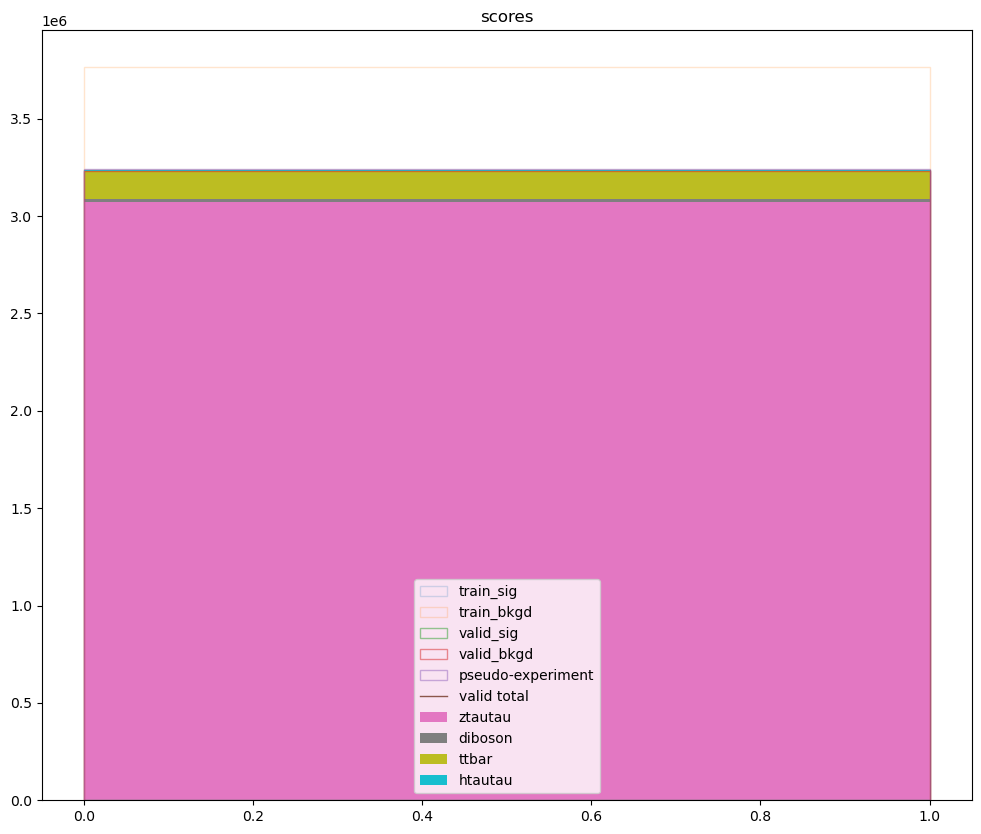

In [41]:
plot_density = False
plot_scaled = False

plt.figure(figsize=(12, 10))
for name, (hist, bins) in histograms.items():
    plt.hist(
        bins[:-1],
        bins,
        weights=hist * ((n_observed / n_expected) if plot_scaled else 1),
        label=name + (' (scaled)' if plot_scaled else ''),
        density=plot_density,
        histtype='step', # if 'train' in name else 'bar',
        alpha=.5 if 'valid' in name else 0.2,
    )
plt.hist(
    hist_bins[:-1],
    hist_bins,
    weights=pseudo_exp_hist[0],
    label='pseudo-experiment',
    density=plot_density,
    histtype='step',
    alpha=.5,
)
plt.stairs(
    histograms['valid_bkgd'][0] + histograms['valid_sig'][0],
    hist_bins,
    label='valid total',
)
# for name, (hist, bins) in test_hist.items():
#     plt.hist(
#         bins[:-1],
#         bins,
#         weights=hist,
#         label=(name + ' (test set)'),
#         density=plot_density,
#         histtype='bar',
#         stacked=True,
#         alpha=.5,
#     )
# tmp_hists = []
# tmp_weights = []
plt.hist(
    # [bins[:-1] for (hist, bins) in test_hist.values()],
    [hist_bins[:-1]] * len(test_hist),
    # test_hist['htautau'][1], # all bins are the same; pick one
    hist_bins,
    weights=[hist for (hist, bins) in test_hist.values()],
    label=[name for name in test_hist],
    density=plot_density,
    histtype='barstacked',
)
# plt.ylim(0, 11e3)
# plt.ylim(1e3, 3e5)
# plt.yscale('log')
plt.legend()
plt.title('scores')

In [42]:

nlls = [
    NLL(
        mu,
        histograms['train_sig'][0] + histograms['train_bkgd'][0],
        histograms['valid_sig'][0],
        histograms['valid_bkgd'][0],
    ) for mu in mus
]

'mu_hat = 5.0'

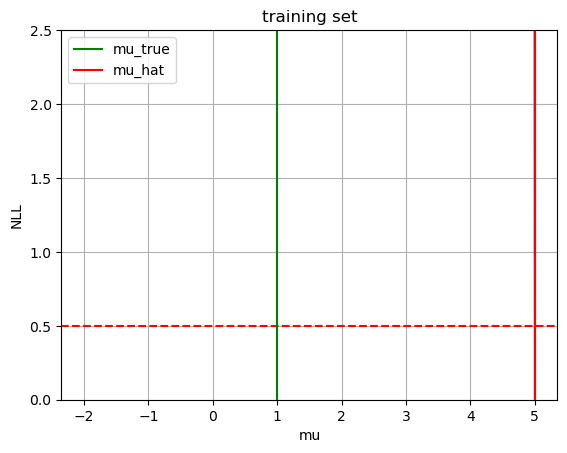

In [43]:
plt.plot(mus, nlls - min(nlls))
plt.axhline(.5, color='r', linestyle='--')
plt.axvline(1, color='g', label='mu_true')
plt.axvline(mus[np.argmin(nlls)], color='r', label='mu_hat')
plt.xlabel('mu')
plt.ylabel('NLL')
plt.ylim(0, 2.5)
plt.grid()
plt.legend()
plt.title('training set')

f'mu_hat = {mus[np.argmin(nlls)]}'

In [71]:
test_nlls = [
    NLL(
        mu,
        # test_hist['htautau'][0] + test_hist['ztautau'][0],
        np.sum([hist for (hist, bins) in test_hist.values()], axis=0),
        histograms['valid_sig'][0],
        histograms['valid_bkgd'][0],
        # scale=(n_observed / n_expected),
    ) for mu in mus
]

Text(0.5, 1.0, 'test set')

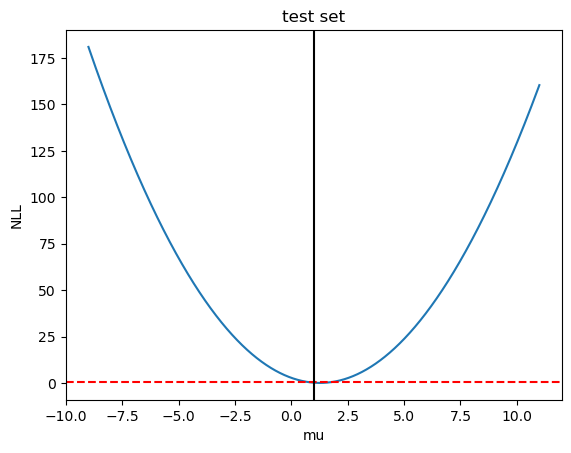

In [73]:
plt.plot(mus, test_nlls - min(test_nlls))
plt.axhline(.5, color='r', linestyle='--')
plt.axvline(1, color='black', label='mu_true')
plt.xlabel('mu')
plt.ylabel('NLL')
# plt.xlim(.75, 1.35)
# plt.ylim(0, 2.5)
plt.title('test set')

In [74]:
pseudo_nlls = [
    NLL(
        mu,
        pseudo_exp_hist[0],
        histograms['valid_sig'][0],
        histograms['valid_bkgd'][0],
        # scale=(n_observed / n_expected),
    ) for mu in mus
]

Text(0.5, 1.0, 'pseudo experiment')

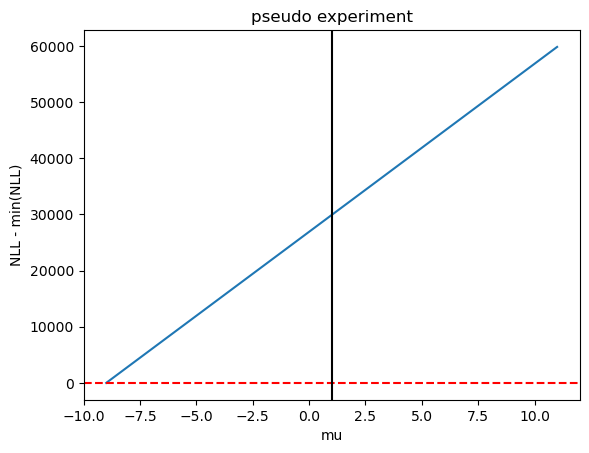

In [76]:
plt.plot(mus, pseudo_nlls - min(pseudo_nlls))
plt.axhline(.5, color='r', linestyle='--')
plt.axvline(1, color='black', label='mu_true')
plt.xlabel('mu')
plt.ylabel('NLL - min(NLL)')
# plt.ylim(0, 2.5)
plt.title('pseudo experiment')

In [ ]:
for name, v in pseudo_exp_data.items():
    print(name, v.shape[0], name in pseudo_exp_data['data'].columns)

In [ ]:
pseudo_exp_counts, pseudo_exp_data['detailed_labels'].value_counts()

In [88]:
seed_init = 3141592653
num_pseudo_experiments = 100
pseudo_results = []
mu_true = 1
pseudo_exp_frac = .1

# for seed in range(seed_init, seed_init + num_pseudo_experiments):
for j in tqdm(range(num_pseudo_experiments), f'Running {num_pseudo_experiments} pseudo-experiments'):
    # print(f'{j / num_pseudo_experiments:.2%} complete', end='\r', flush=True)
    seed = seed_init + j
    pseudo_exp_data, pseudo_exp_counts = ingestion.data.generate_pseudo_exp_data(mu_true, seed=seed, return_counts=True, lhc_frac=pseudo_exp_frac)
    # pseudo_exp_data = {name: v[:int(v.shape[0] / 10 + .5)] for name, v in pseudo_exp_data.items()} # only keep the first 10% of the data
    # pseudo_exp_counts = pseudo_exp_data['detailed_labels'].value_counts().to_dict()
    pseudo_exp_data['scores'] = ingestion.model.model.predict(pseudo_exp_data['data'], verbose=0)
    pseudo_exp_hist = np.histogram(
        pseudo_exp_data['scores'], # testing using the labels in place of the scores
        bins=hist_bins,
    )
    # pseudo_nlls = NLLarray(mus, pseudo_exp_hist[0], histograms['valid_sig'][0], histograms['valid_bkgd'][0])
    pseudo_nlls = [
        NLL(
            mu,
            pseudo_exp_hist[0],
            histograms['valid_sig'][0] * pseudo_exp_frac,
            histograms['valid_bkgd'][0] * pseudo_exp_frac,
        ) for mu in mus
    ]
    pseudo_results.append((seed, get_results(mus, pseudo_nlls), pseudo_exp_counts))

Running 100 pseudo-experiments: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


In [89]:
intervals = np.array([result[1][1] for result in pseudo_results])

In [90]:
def sigma_fractions(intervals, mu_true=1, max_sigma=5):
    def n_sigma(n, means, intervals):
        return n * (intervals - means[:, None]) + means[:, None]
    means = intervals.mean(1)
    num_samples = intervals.shape[0]
    frac_within = [
        ((n_sigma(j, means, intervals)[:, 0] < mu_true) & (mu_true < n_sigma(j, means, intervals)[:, 1])).sum() / num_samples
        for j in range(1, max_sigma + 1)
    ]
    return frac_within

In [91]:
for j, frac in enumerate(sigma_fractions(intervals, mu_true)):
    print(f'fraction within {j+1} sigma: {frac:.2f}')

fraction within 1 sigma: 0.67
fraction within 2 sigma: 0.92
fraction within 3 sigma: 0.99
fraction within 4 sigma: 1.00
fraction within 5 sigma: 1.00


In [92]:
# for *_, counts in pseudo_results:
#     print(counts['htautau'] / mu_true)

valid_set['weights'][valid_set['labels'] == 1].sum(), test_set['htautau'].shape[0], np.mean([counts['htautau'] for *_, counts in pseudo_results])

(3322.0484428133336, 16536, 329.78)

In [93]:
tmp_stats = {}

In [108]:
tmp_stats['ddof'] = 1

tmp_stats['mu_hat_mean'] = intervals.mean()
tmp_stats['mu_hat_std'] = intervals.mean(1).std(ddof=tmp_stats['ddof'])
tmp_stats['mu_hat_stderr'] = tmp_stats['mu_hat_std'] / np.sqrt(intervals.shape[0])
tmp_stats['width_mean'] = (intervals[:, 1] - intervals[:, 0]).mean()
tmp_stats['width_std'] = (intervals[:, 1] - intervals[:, 0]).std(ddof=tmp_stats['ddof'])

In [109]:
tmp_stats

{'ddof': 1,
 'mu_hat_mean': 1.4694369436943695,
 'mu_hat_std': 1.866108312258857,
 'mu_hat_stderr': 0.1866108312258857,
 'width_mean': 3.423962396239624,
 'width_std': 0.0033360297352476695}

In [110]:
tmp_stats['mu_hat_std'] * 2, tmp_stats['width_mean']

(3.732216624517714, 3.423962396239624)

In [97]:
(tmp_stats['mu_hat_mean'] - mu_true) / tmp_stats['mu_hat_stderr']

2.5155932300957007

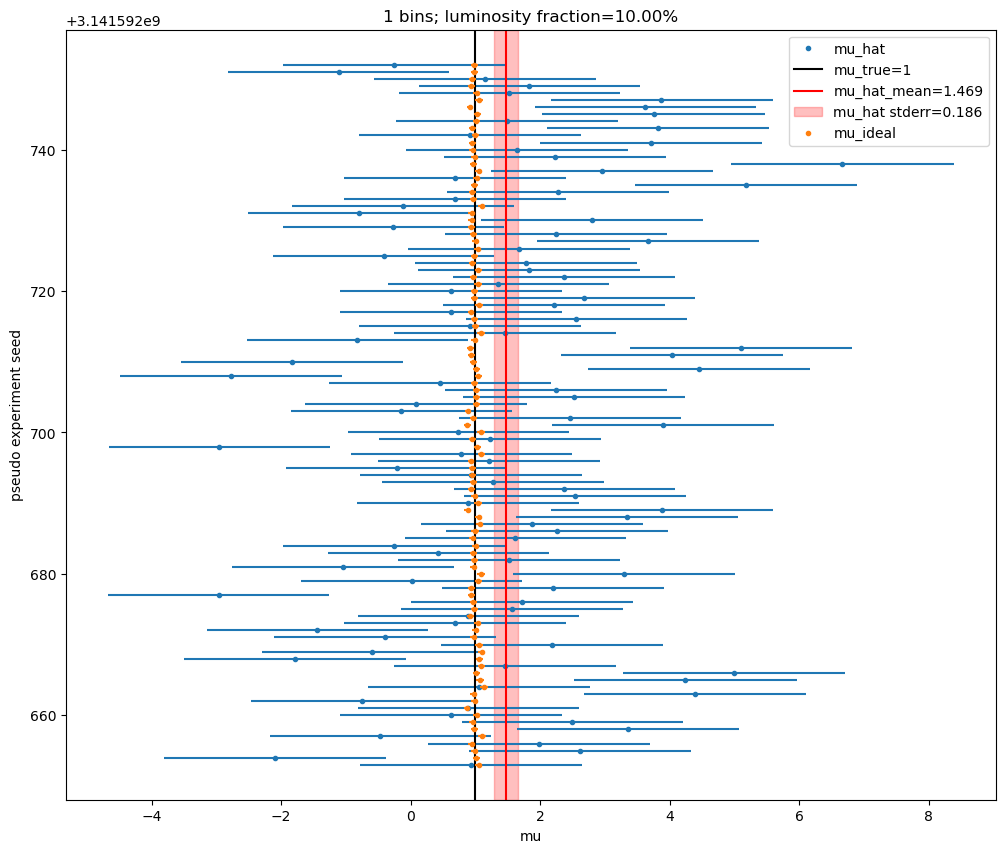

In [111]:
plt.figure(figsize=(12, 10))
# plot mu_hat
plt.plot(
    [result[1][0] for result in pseudo_results],
    [seed for seed, *_ in pseudo_results],
    '.',
    label='mu_hat',
    # alpha=0.5,
)
# plot mu_hat error bars
plt.hlines(
    [seed for seed, *_ in pseudo_results],
    [result[1][1][0] for result in pseudo_results],
    [result[1][1][1] for result in pseudo_results],
    # linestyles='solid',
    # label='p16-p84',
    # alpha=0.5,
)
# plot mu_true
plt.axvline(mu_true, color='black', label=f'{mu_true=}')
# plot mu_hat mean
plt.axvline(intervals.mean(1).mean(), color='r', label=f'mu_hat_mean={intervals.mean(1).mean():.3f}')
# plot mu_hat stderr
plt.axvspan(
    intervals.mean() - intervals.mean(1).std() / np.sqrt(intervals.shape[0]),
    intervals.mean() + intervals.mean(1).std() / np.sqrt(intervals.shape[0]),
    color='r',
    alpha=0.25,
    label=f'mu_hat stderr={intervals.mean(1).std() / np.sqrt(intervals.shape[0]):.3f}',
)
plt.xlabel('mu')
plt.ylabel(f'pseudo experiment seed')
# plt.twiny()
# plot mu_ideal = sig_observed / sig_expected
plt.plot(
    [counts['htautau'] / (pseudo_exp_frac * valid_set['weights'][valid_set['labels'] == 1].sum()) for *_, counts in pseudo_results],
    [seed for seed, *_ in pseudo_results],
    '.',
    color='C1',
    label='mu_ideal',
    # alpha=0.5,
)
# plot mu_ideal error bars
plt.hlines(
    [seed for seed, *_ in pseudo_results],
    [(counts['htautau'] - np.sqrt(counts['htautau'])) / (pseudo_exp_frac * valid_set['weights'][valid_set['labels'] == 1].sum()) for *_, counts in pseudo_results],
    [(counts['htautau'] + np.sqrt(counts['htautau'])) / (pseudo_exp_frac * valid_set['weights'][valid_set['labels'] == 1].sum()) for *_, counts in pseudo_results],
    color='C1',
    # linestyles='dashed',
    # label='p16-p84 poisson',
    # alpha=0.5,
)
# plt.xlim(0, 3)
plt.title(f'{num_bins} bins; luminosity fraction={pseudo_exp_frac:.2%}')
plt.legend()

In [104]:
len(hist_bins) - 1, (mus[0], mus[-1], len(mus))

(1, (-9.0, 11.0, 10000))

In [ ]:
plt.hist(
    (intervals.mean(1) - mu_true) / ((intervals[:, 1] - intervals[:, 0]) / 2), # pulls
    bins=20,
)
plt.xlabel('pull')

In [ ]:
for name in valid_set['data'].columns:
    if valid_set['data'][name].dtype != np.float32:
        print('Train:', name, valid_set['data'][name].dtype)
    if pseudo_exp_data['data'][name].dtype != np.float32:
        print('Test: ', name, pseudo_exp_data['data'][name].dtype)

In [ ]:
def pull_hist(intervals, mu_true=1, bins=100):
    pulls = (intervals.mean(1) - mu_true) / ((intervals[:, 1] - intervals[:, 0]) / 2)
    return np.histogram(pulls, bins=bins)

In [ ]:
plt.plot((intervals[:, 1] - intervals[:, 0]) / 2, '.')
plt.xlabel('pseudo experiment')
plt.ylabel('one sigma width')
# plt.twinx()
# plt.plot(intervals.mean(1), '.', color='r')
# plt.ylabel('mu_hat')

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [ ]:
def visualize_scatter(ingestion_result_dict, ground_truth_mus):
    plt.figure(figsize=(6, 4))
    for key in ingestion_result_dict.keys():
        ingestion_result = ingestion_result_dict[key]
        mu_hat = np.mean(ingestion_result["mu_hats"])
        mu = ground_truth_mus[key]
        plt.scatter(mu, mu_hat, c='b', marker='o')
    
    plt.xlabel('Ground Truth $\mu$')
    plt.ylabel('Predicted $\mu$ (averaged for 100 test sets)')
    plt.title('Ground Truth vs. Predicted $\mu$ Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def visualize_coverage(ingestion_result_dict, ground_truth_mus):

    for key in ingestion_result_dict.keys():
        plt.figure( figsize=(5, 5))

        ingestion_result = ingestion_result_dict[key]
        mu = ground_truth_mus[key]
        mu_hats = np.mean(ingestion_result["mu_hats"])
        p16s = ingestion_result["p16"]
        p84s = ingestion_result["p84"]
        
        # plot horizontal lines from p16 to p84
        for i, (p16, p84) in enumerate(zip(p16s, p84s)):
            plt.hlines(y=i, xmin=p16, xmax=p84, colors='b', label='p16-p84')

        plt.vlines(x=mu_hats, ymin=0, ymax=len(p16s), colors='r', linestyles='dashed', label='Predicted $\mu$')
        plt.vlines(x=mu, ymin=0, ymax=len(p16s), colors='g', linestyles='dashed', label='Ground Truth $\mu$')
        plt.xlabel('mu')
        plt.ylabel('pseudo-experiments')
        plt.title(f'mu distribution - Set_{key}')
        plt.legend()
        
    plt.show()


In [ ]:
from score import Scoring

In [ ]:
# Initialize Score
score = Scoring()

In [ ]:
score.load_ingestion_results(output_dir)

In [ ]:
# Compute Score
score.compute_scores(test_settings)

In [ ]:
# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

In [ ]:
# Visualize coverage
visualize_coverage(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

***
# Submission
***

### **Prepare the submission**

In [ ]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'HiggsML-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `HEP-Challenge/")